### Mount gg drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Đưa đến nhánh MyDrive

In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

### Thư viện cần thiết

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io

import time
import torch.nn.functional as F

import glob
from PIL import Image

import gait_recognition.utils
import gait_recognition.augmentation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()
print(device)

cuda


In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

### Đường dẫn đến file train và file valid (sử dụng dữ liệu từ github của GaitGraph chưa sử dụng thêm dữ liệu ngoài)

In [5]:
train_file_path = "/content/drive/MyDrive/gait_recognition/train.csv"
test_file_path = "/content/drive/MyDrive/gait_recognition/test.csv"

### Xây dựng class Graph để tạo các ma trận liền kề A với số hop khác nhau

In [6]:
class Graph():
    def __init__(self, dataset, max_hop=3, dilation=1):
        self.dataset = dataset.split('-')[0]
        self.max_hop = max_hop
        self.dilation = dilation

        # get edges
        self.num_node, self.edge, self.connect_joint = self._get_edge()

        # get adjacency matrix
        self.A = self._get_adjacency()

    def __str__(self):
        return self.A

    def _get_edge(self):
        if self.dataset == 'coco':
            # keypoints = {
            #     0: "nose",
            #     1: "left_eye",
            #     2: "right_eye",
            #     3: "left_ear",
            #     4: "right_ear",
            #     5: "left_shoulder",
            #     6: "right_shoulder",
            #     7: "left_elbow",
            #     8: "right_elbow",
            #     9: "left_wrist",
            #     10: "right_wrist",
            #     11: "left_hip",
            #     12: "right_hip",
            #     13: "left_knee",
            #     14: "right_knee",
            #     15: "left_ankle",
            #     16: "right_ankle"
            # }
            num_node = 17
            self_link = [(i, i) for i in range(num_node)]
            neighbor_link = [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6),
                             (5, 7), (7, 9), (6, 8), (8, 10), (5, 11), (6, 12), (11, 12),
                             (11, 13), (13, 15), (12, 14), (14, 16)]
            self.edge = self_link + neighbor_link
            edge = self.edge
            self.center = 0
            self.connect_joint = np.array([5,0,0,1,2,0,0,5,6,7,8,5,6,11,12,13,14])
            connect_joint = self.connect_joint
        return num_node, edge, connect_joint

    def _get_hop_distance(self):
        A = np.zeros((self.num_node, self.num_node))
        for i, j in self.edge:
            A[j, i] = 1
            A[i, j] = 1
        hop_dis = np.zeros((self.num_node, self.num_node)) + np.inf
        transfer_mat = [np.linalg.matrix_power(A, d) for d in range(self.max_hop + 1)]
        arrive_mat = (np.stack(transfer_mat) > 0)
        for d in range(self.max_hop, -1, -1):
            hop_dis[arrive_mat[d]] = d
        return hop_dis

    def _get_adjacency(self):
        hop_dis = self._get_hop_distance()
        valid_hop = range(0, self.max_hop + 1, self.dilation)
        adjacency = np.zeros((self.num_node, self.num_node))
        for hop in valid_hop:
            adjacency[hop_dis == hop] = 1
        normalize_adjacency = self._normalize_digraph(adjacency)
        A = np.zeros((len(valid_hop), self.num_node, self.num_node))
        for i, hop in enumerate(valid_hop):
            A[i][hop_dis == hop] = normalize_adjacency[hop_dis == hop]
        return A

    def _normalize_digraph(self, A):
        Dl = np.sum(A, 0)
        num_node = A.shape[0]
        Dn = np.zeros((num_node, num_node))
        for i in range(num_node):
            if Dl[i] > 0:
                Dn[i, i] = Dl[i]**(-1)
        AD = np.dot(A, Dn)
        return AD

### Kiểm tra ma trận liền kề A

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 6), (5, 6), (5, 7), (7, 9), (6, 8), (8, 10), (5, 11), (6, 12), (11, 12), (11, 13), (13, 15), (12, 14), (14, 16)]
[[[0.14285714 0.         0.         ... 0.         0.         0.        ]
  [0.         0.11111111 0.         ... 0.         0.         0.        ]
  [0.         0.         0.11111111 ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.11111111 0.         0.        ]
  [0.         0.         0.         ... 0.         0.2        0.        ]
  [0.         0.         0.         ... 0.         0.         0.2       ]]

 [[0.         0.11111111 0.11111111 ... 0.         0.         0.        ]
  [0.14285714 0.         0.         ... 0.         0.         0.        ]
  [0.14285714 0.         0.         ... 0.         0.         0.        ]
  ...
  [0.       

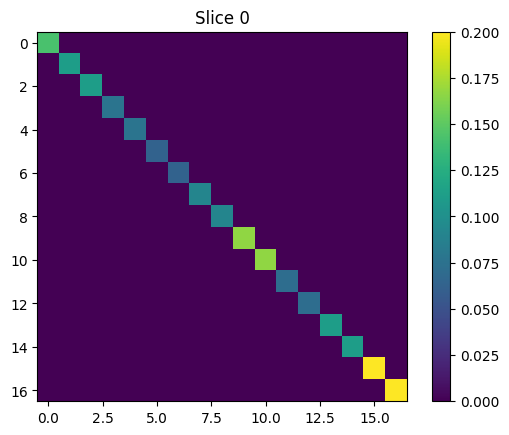

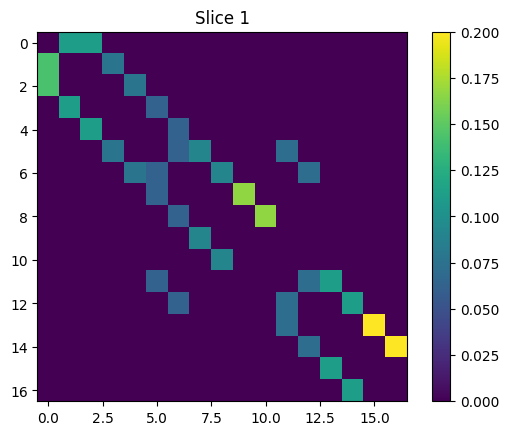

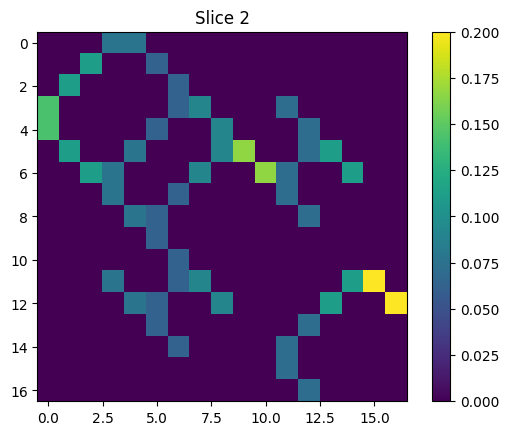

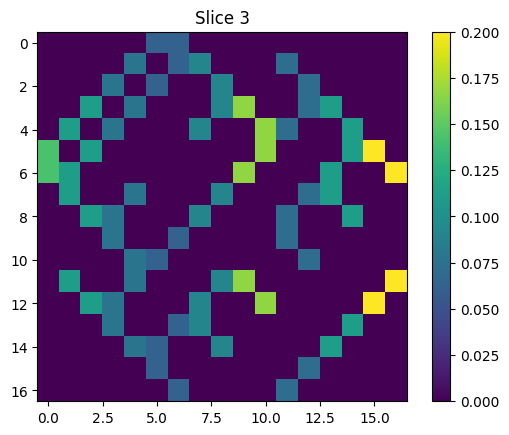

In [7]:
graph = Graph("coco")
print(graph.edge)
print(graph.A)
for i in range(graph.A.shape[0]):
    plt.imshow(graph.A[i,:,:], cmap='viridis')
    plt.title(f"Slice {i}")
    plt.colorbar()
    plt.show()

In [8]:
print(graph.A.shape) #(K,V,V) or (K,V,W)

(4, 17, 17)


### Một số Augmentation (Các augmentation được custom bởi GaitGraph)

In [9]:
train_transform = transforms.Compose(
        [
            gait_recognition.augmentation.MirrorPoses(0.5),
            gait_recognition.augmentation.FlipSequence(0.5),
            gait_recognition.augmentation.RandomSelectSequence(60),
            #augmentation.ShuffleSequence(True),
            gait_recognition.augmentation.PointNoise(0.05),
            gait_recognition.augmentation.JointNoise(0.1),
            # augmentation.MultiInput(graph.connect_joint, False),
            gait_recognition.augmentation.ToTensor()
        ],
    )
print(train_transform)

Compose(
)


In [10]:
test_transform = transforms.Compose(
        [
            gait_recognition.augmentation.SelectSequenceCenter(60),
            # augmentation.MultiInput(graph.connect_joint, False),
            gait_recognition.augmentation.ToTensor()
        ],
    )
print(test_transform)

Compose(
)


### Xây dựng class custom để tạo Dataset từ đường dẫn vào file data

In [11]:
class PoseDataset(Dataset):
    """
    Args:
     data_list_path (string):   Path to pose data.
     sequence_length:           Length of sequence for each data point. The number of frames of pose data returned.
     train:                     Training dataset or validation. default : True
     transform:                 Transformation on the dataset
     target_transform:          Transformation on the target.
    """

    def __init__(
        self,
        data_list_path,
        sequence_length=1,
        train=True,
        transform=None,
        target_transform=None,
    ):
        super(PoseDataset, self).__init__()
        self.data_list = np.loadtxt(data_list_path, skiprows=1, dtype=str)
        self.sequence_length = sequence_length
        self.train = train

        self.transform = transform
        self.target_transform = target_transform

        self.data_dict = {}
        self.target_dict = {}

        for row in self.data_list:
            row = row.split(",")

            key, frame_num, target_id = self._filename_to_target(row[0])

            if key not in self.data_dict:
              self.data_dict[key] = {}
              self.target_dict[key] = target_id

            if len(row[1:]) != 51:
                print("Invalid pose data for: ", key, ", frame: ", frame_num)
                continue
            # Added try block to see if all the joint values are present. other wise skip that frame.
            try:
                self.data_dict[key][frame_num] = np.array(
                    row[1:], dtype=np.float32
                ).reshape((-1, 3))
            except ValueError:
                print("Invalid pose data for: ", key, ", frame: ", frame_num)
                continue

        # Check for data samples that have less than sequence_length frames and remove them.
        for key in list(self.data_dict.keys()):
            if len(self.data_dict[key]) < self.sequence_length + 1:
                del self.data_dict[key]
                del self.target_dict[key]

        self.targets = [self.target_dict[k] for k in self.data_dict.keys()]
        self.data = list(self.data_dict.values())

    def _filename_to_target(self, filename):
        raise NotImplemented()

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):

        target = self.targets[index]
        data = np.stack(list(self.data[index].values()))

        if self.transform is not None:
            data = self.transform(data)
            data = np.transpose(data, (2, 0, 1))

        if self.target_transform is not None:
            target = self.target_transform(target)

        return data, target


class CasiaBPose(PoseDataset):
    """
    CASIA-B Dataset
    The format of the video filename in Dataset B is 'xxx-mm-nn-ttt.avi', where
      xxx: subject id, from 001 to 124.
      mm: walking status, can be 'nm' (normal), 'cl' (in a coat) or 'bg' (with a bag).
      nn: sequence number.
      ttt: view angle, can be '000', '018', ..., '180'.
     """

    mapping_walking_status = {
        'nm': 0,
        'bg': 1,
        'cl': 2,
    }

    def _filename_to_target(self, filename):
      _, sequence_id, frame = filename.split("/")
      subject_id, walking_status, sequence_num, view_angle = sequence_id.split("-")

      # Dùng các thông tin khác để tạo key phân biệt rõ sequence
      key = f"{subject_id}_{walking_status}_{sequence_num}_{view_angle}"

      # Chỉ trả về ID làm nhãn (target)
      return key, int(frame[:-4]), int(subject_id)-1

def dataset_factory(name):
    if name == "casia-b":
        return CasiaBPose

    raise ValueError()

### Tạo dataset và tạo các batch bằng Dataloader với batch size bằng 128

In [12]:
dataset_class = dataset_factory('casia-b')
train_dataset = dataset_class(train_file_path, train=True, sequence_length=60, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
train_N = len(train_loader.dataset)
print(train_N)

# valid_dataset = dataset_class(valid_file_path, sequence_length=60, transform=valid_transform)
# valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, drop_last=True)
# valid_N = len(valid_loader.dataset)
# print(valid_N)

test_dataset = dataset_class(test_file_path, sequence_length=60, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
test_N = len(test_loader.dataset)
print(test_N)

7989
5352


### Kiểm tra một batch trong train loader

In [ ]:
batch = next(iter(train_loader))  # Lấy batch đầu tiên
x, y = batch  # Tách hình ảnh (x) và nhãn (y)
# x = torch.stack(x)
# y = torch.stack(y)

# In thông tin batch
print("Batch x type:", type(x))
print("Batch x shape:", x.shape)  # (N, C, T, V)
print("Batch y shape:", y.shape)  # (C,N)
print(y)

Batch x type: <class 'torch.Tensor'>
Batch x shape: torch.Size([128, 3, 60, 17])
Batch y shape: torch.Size([128])
tensor([123,  41,  92,  99,  18, 119,  78, 114,  76,  13,  18, 107, 107,  52,
         57,  22,  72,  69,  67,  45,  58,   6,  85,  22,  23,  37, 121,  69,
         43,  16, 115,  63,  54,  80,  70,  56, 115, 110,  25,  96,  26,  35,
         28,  64,  51, 105,  63,  69,   9, 103,  46,  26,   7, 103,  95,  33,
         75, 121,  78,  70,  50,   5,  64,  62,  67,  79,  46, 117, 120,   4,
         40,  63,  56,  68, 119,  44,  58,  23,  63,  25,  71, 118,  36,  30,
         26,  77,  72,   3,  59, 100, 106,  86,  99,  93,  86,  42,  97, 118,
          3,  47, 100,  45,  63,  22, 121,  59,   7, 105,  38,  96,  67,  77,
          5,  41, 115,  80, 100,   9,  32, 102,  20,  54,  79,   2,  94,  21,
        113,  40])


### Kiểm tra khung xương có theo chuẩn COCO không từ dữ liệu input kích thước (3, 60, 17)

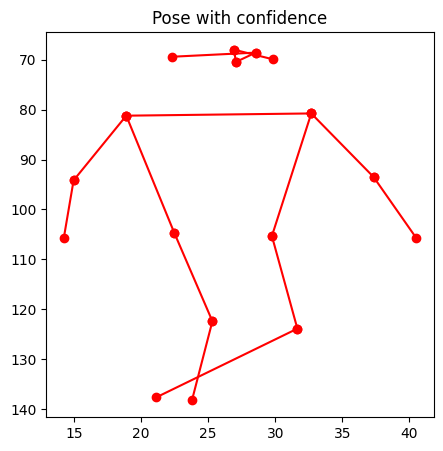

In [ ]:
skeleton_edges = [
    (0, 1), (0, 2),
    (1, 3), (2, 4),
    (5, 6),
    (5, 7), (7, 9),
    (6, 8), (8, 10),
    (5, 11), (6, 12),
    (11, 13), (13, 15),
    (12, 14), (14, 16)
]

pose = x[0, :, 0, :]  # [3, 17]

# x, y
xs = pose[0].numpy()
ys = pose[1].numpy()
conf = pose[2].numpy()

# Vẽ pose với kích thước điểm theo confidence
plt.figure(figsize=(5, 5))
for (i, j) in skeleton_edges:
    plt.plot([xs[i], xs[j]], [ys[i], ys[j]], 'ro-')
plt.scatter(xs, ys, s=conf, c='b')
plt.gca().invert_yaxis()
plt.title('Pose with confidence')
plt.show()

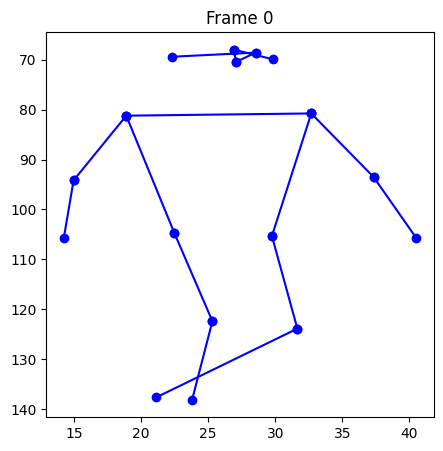

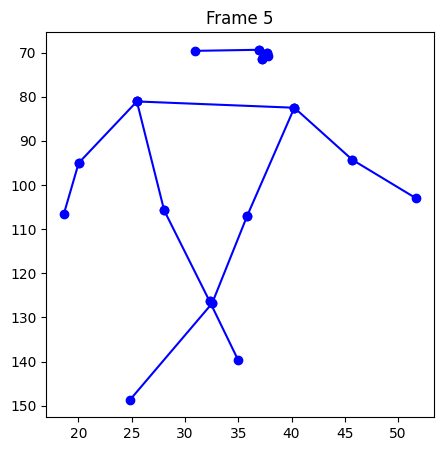

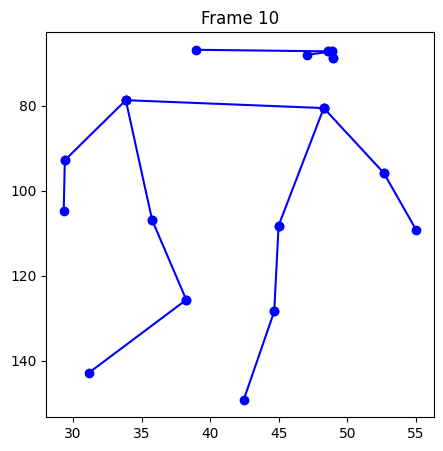

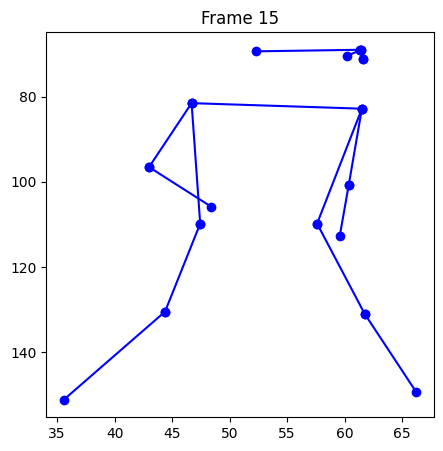

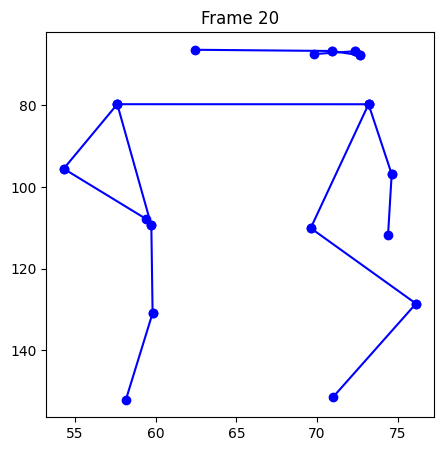

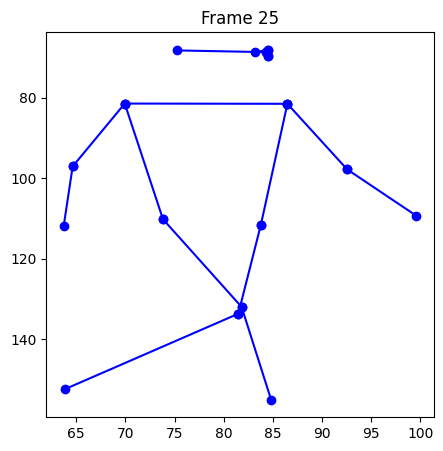

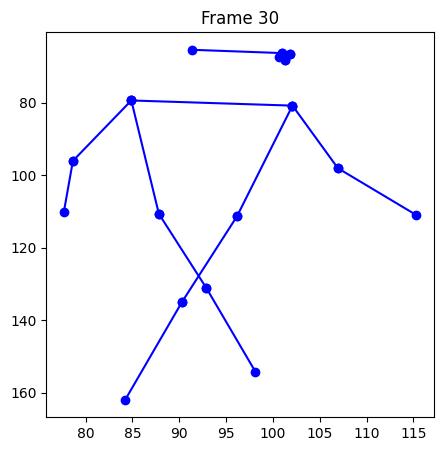

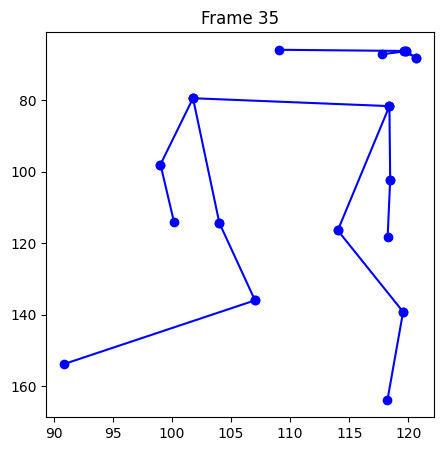

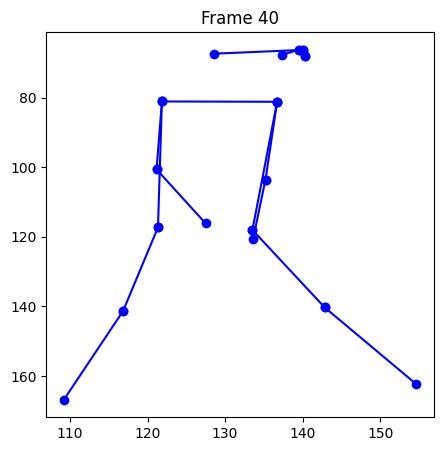

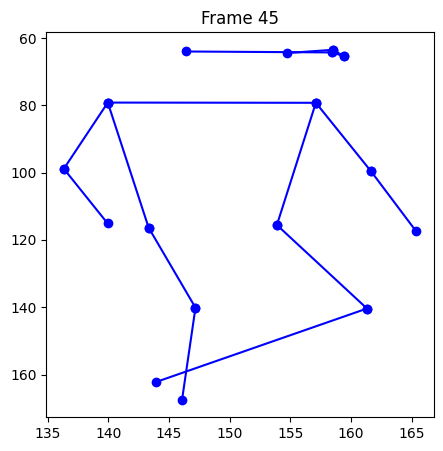

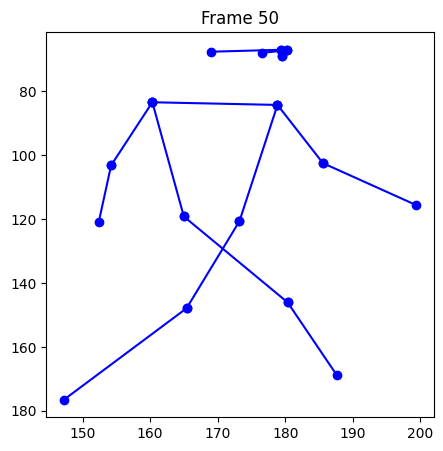

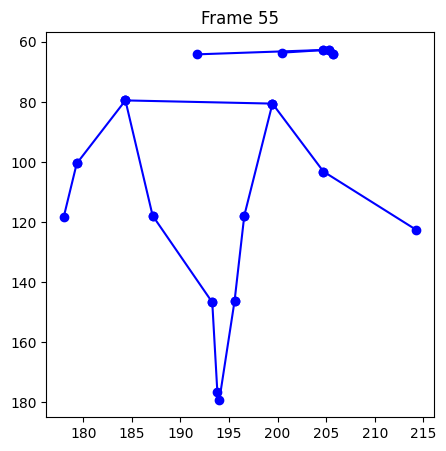

In [ ]:
for t in range(0, 60, 5):  # nhảy 5 frame
    pose = x[0, :, t, :]
    xs, ys,conf = pose[0].numpy(), pose[1].numpy(), pose[2].numpy()

    plt.figure(figsize=(5, 5))
    for (i, j) in skeleton_edges:
        plt.plot([xs[i], xs[j]], [ys[i], ys[j]], 'bo-')
    plt.scatter(xs, ys, s=conf, c='b')
    plt.title(f'Frame {t}')
    plt.gca().invert_yaxis()
    plt.show()

## Xây dựng mô hình Spatial Temporal Graph Convolution Network

* Xây dựng class GraphicalConvNet để xử lí việc lan truyền các dữ liệu tại 17 nút trong một khung xương tại một khung frame
* Xây dựng module st_gcn để gồm 2 khối GCN và TCN ,khối TCN xử lí dữ liệu thông tin tại một nút trong chuỗi 60 nút giống nhau liên tiếp bằng việc tích chập với kernel 1 chiều kích thước temporal_window_size

In [13]:
class GraphicalConvNet(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 t_kernel_size=1,
                 t_stride=1,
                 t_padding=0,
                 t_dilation=1,
                 bias=True):
        super().__init__()

        self.kernel_size = kernel_size
        # Ở đây kernel size = 4 vì có 4 adjacency matrix với số hop khác nhau
        # Mỗi adjacency matrix sẽ có C channel của riêng nó để lan truyền thông tin => in_channel sau conv sẽ ra 4 * out_channel
        self.conv = nn.Conv2d(
            in_channels,
            out_channels * kernel_size,
            kernel_size=(t_kernel_size, 1),
            padding=(t_padding, 0),
            stride=(t_stride, 1),
            dilation=(t_dilation, 1),
            bias=bias)

    def forward(self, x, A):
        assert A.size(0) == self.kernel_size

        x = self.conv(x)

        n, kc, t, v = x.size() # k=4
        x = x.view(n, self.kernel_size, kc//self.kernel_size, t, v) # Tách (N, KC, T, V) ra (N, K, C, T, V)

        # Lan truyền thông tin trên từng adjacency matrix đến từng node V
        # Sau đó sum tất cả thông tin lan truyền lại với nhau , kết quả là một vector mới với mỗi node là một trọng số mới (N, C, T, W)
        x = torch.einsum('nkctv,kvw->nctw', (x, A))

        return x.contiguous()

class st_gcn(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dropout=0,
                 residual=True):
        super(st_gcn, self).__init__()

        # L_out = ((L_in + 2 x padding - kernel_size) / stride) + 1 => padding
        # Cần padding = 4 để khi Conv2D kernel size = (9,1) để  không bị mất kết quả node ở 4 frame đầu khi Conv2D cho từng node trong chuỗi 9 frame liên tiếp
        padding = ((kernel_size[0] - 1) // 2, 0) # kernel_size[0] = temporal_window_size = 9

        self.gcn = GraphicalConvNet(in_channels, out_channels, kernel_size[1]) #Output: x(N,C,T,W) and A(K,V,W)

        # Số channel qua lớp TCN sẽ giữ nguyên vì đã được up sample ở lớp GCN
        # Giữ nguyên để theo cấu trục mạng TCN là sau khi có được output lớp TCN thì sẽ cộng output cho residual(X)
        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                (kernel_size[0], 1),
                # Nếu stride = 2 thì giảm T một nửa , V giữ nguyên (N, C, T/2, W),
                # tương tự max pooling nhưng chi giảm số lượng frame T, giữ nguyên thông tin W
                (stride, 1),
                padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout, inplace=True),
        )

        if not residual:
            self.residual = lambda x: 0 # Nếu residual = False thì không có skip connection giữa ouput TCN với residual(X)

        elif (in_channels == out_channels) and (stride == 1):
            self.residual = lambda x: x

        else:
            self.residual = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=(stride, 1)), # Nếu stride = 2 thì giảm T một nửa , W giữ nguyên (N, C, T/2, W)
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, A):

        res = self.residual(x)
        x = self.gcn(x, A)
        x = self.tcn(x) + res

        return self.relu(x)

### Mô hình ST-GCN gồm nhiều module st_gcn và một lớp Linear cuối để đưa về số chiều bằng với num_class để tính toán loss

In [14]:
class STGCN_Model(nn.Module):

    def __init__(self, num_class):
        super(STGCN_Model, self).__init__()

        # load graph
        self.graph = Graph("coco")
        A = torch.tensor(self.graph.A, dtype=torch.float32, requires_grad=False) # (K,V,V or W)
        self.register_buffer('A', A)

        # build networks
        spatial_kernel_size = A.size(0) # spatial_kernel_size = 4
        temporal_kernel_size = 9
        kernel_size = (temporal_kernel_size, spatial_kernel_size) # kernel_size[0] = 9, kernel_size[1] = 4
        self.data_bn = nn.BatchNorm1d(3 * A.size(1)) # A.size(1) = 17
        self.st_gcn_networks = nn.ModuleList((
            st_gcn(3, 64, kernel_size, 1, residual=False, dropout=0.5),
            st_gcn(64, 64, kernel_size, 1, dropout=0.5),
            st_gcn(64, 64, kernel_size, 1, dropout=0.5),
            st_gcn(64, 64, kernel_size, 1, dropout=0.5),
            st_gcn(64, 128, kernel_size, 2, dropout=0.5),
            st_gcn(128, 128, kernel_size, 1, dropout=0.5),
            st_gcn(128, 128, kernel_size, 1, dropout=0.5),
            st_gcn(128, 256, kernel_size, 2, dropout=0.5),
            st_gcn(256, 256, kernel_size, 1, dropout=0.5),
            st_gcn(256, 256, kernel_size, 1, dropout=0.5),
        ))

        # fcn for prediction
        self.fcn = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Flatten(start_dim=1),  # Flatten từ (N, num_class, H, W) -> (N, num_class * H * W)
            nn.Linear(128, num_class)
        )

    def forward(self, x):
        N, C, T, V = x.size()

        # data normalization
        x = x.permute(0, 1, 3, 2).contiguous()  # (N, C, V, T)
        x = x.view(N, C * V, T)
        x = self.data_bn(x)
        x = x.view(N, C, V, T)
        x = x.permute(0, 1, 3, 2).contiguous()
        x = x.view(N, C, T, V)

        # forward
        for layer in self.st_gcn_networks:
            x = layer(x, self.A)

        # global pooling
        x = F.avg_pool2d(x, x.size()[2:])  # Pool hết (T, V)

        # prediction
        x = self.fcn(x)

        return x

### Số lượng class là 124 (ban đầu theo dữ liệu của GaitGraph)

In [15]:
num_class = 124

my_model = STGCN_Model(num_class = num_class).to(device)

### Summary model

In [16]:
from torchsummary import summary

summary(my_model, input_size=(3, 60, 17), batch_size = 128, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1              [128, 51, 60]             102
            Conv2d-2         [128, 256, 60, 17]           1,024
  GraphicalConvNet-3          [128, 64, 60, 17]               0
       BatchNorm2d-4          [128, 64, 60, 17]             128
              ReLU-5          [128, 64, 60, 17]               0
            Conv2d-6          [128, 64, 60, 17]          36,928
       BatchNorm2d-7          [128, 64, 60, 17]             128
           Dropout-8          [128, 64, 60, 17]               0
              ReLU-9          [128, 64, 60, 17]               0
           st_gcn-10          [128, 64, 60, 17]               0
           Conv2d-11         [128, 256, 60, 17]          16,640
 GraphicalConvNet-12          [128, 64, 60, 17]               0
      BatchNorm2d-13          [128, 64, 60, 17]             128
             ReLU-14          [128, 64,

### Một số hàm cơ bản cho logging, lưu mô hình tốt nhất và bắt buộc dừng train

In [17]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

class SaveModel:
    def __init__(self, save_path="model.pth"):
        """
        patience: Số epoch không cải thiện trước khi dừng training
        min_delta: Ngưỡng thay đổi nhỏ nhất để tính là có cải thiện
        save_path: Đường dẫn để lưu model tốt nhất
        """
        self.best_loss = float('inf')
        self.best_acc = 0.0
        self.save_path = save_path

    def __call__(self, valid_loss, valid_acc, model , optimizer):
        # Kiểm tra nếu có cải thiện về loss hoặc accuracy
        if valid_acc > self.best_acc:
            self.best_acc = valid_acc
            # Lưu lại model fine-tuning tốt nhất
            torch.save(model.state_dict(), self.save_path)
            print(f"✅ Model saved with valid loss: {valid_loss:.4f} , valid accuracy: {valid_acc:.4f} , lr: {get_lr(optimizer):.6f}")

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        """
        patience: Số epoch không cải thiện trước khi dừng training
        min_delta: Ngưỡng thay đổi nhỏ nhất để tính là có cải thiện
        save_path: Đường dẫn để lưu model tốt nhất
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.best_acc = 0.0
        self.counter = 0

    def __call__(self, valid_loss):
        # Kiểm tra nếu có cải thiện về loss hoặc accuracy
        if valid_loss < self.best_loss - self.min_delta:
            self.best_loss = valid_loss
            self.counter = 0  # Reset bộ đếm nếu có cải thiện
        else:
            self.counter += 1  # Tăng bộ đếm nếu không cải thiện

        return self.counter >= self.patience

### Hàm training và validating

In [18]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from torch.cuda.amp import autocast, GradScaler

def valid(model, val_loader, loss_function):
    model.eval()
    total_loss = 0
    total_acc = 0
    val_N = len(val_loader.dataset)

    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device , non_blocking=True), targets.to(device, non_blocking=True)

            outputs = model(data)
            loss = loss_function(outputs, targets)

            acc = (outputs.argmax(dim=1) == targets).float().sum().item()

            total_loss += loss.item()
            total_acc += acc

    avg_acc = total_acc / val_N

    return total_loss, avg_acc

# Hàm huấn luyện một epoch với One-Cycle Learning Rate
def train_one_epoch(model, train_loader, optimizer, loss_function, scaler):
    model.train()
    total_loss = 0
    total_accuracy = 0
    train_N = len(train_loader.dataset)  # Tổng số mẫu trong tập train

    for data, targets in train_loader:

        data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        with autocast():
            output = model(data)
            loss = loss_function(output, targets)
        acc = (output.argmax(dim=1) == targets).float().sum().item()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        total_accuracy += acc

    avg_acc = total_accuracy / train_N

    return total_loss, avg_acc

# Hàm train tổng thể với One-Cycle Learning Rate
def fit_one_cycle(epochs, model, train_loader, val_loader, loss_function,
                  optimizer, save_path="/content/drive/MyDrive/gait_recognition/stgcn_model_2.pth"):

    cost_train = []
    acc_train = []
    cost_valid = []
    acc_valid = []

    early_stopping = EarlyStopping(patience=20, min_delta=0.01)
    save_model = SaveModel(save_path = save_path)
    scaler = GradScaler()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_function, scaler)

        valid_loss, valid_acc = valid(model, val_loader, loss_function)

        scheduler.step(valid_loss)

        print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, LR: {get_lr(optimizer):.6f}")
        print(f"Validation loss: {valid_loss:.4f}, Validation acc: {valid_acc:.4f}")

        if epoch % 10 == 0:
            cost_train.append(train_loss)
            acc_train.append(train_acc)
            cost_valid.append(valid_loss)
            acc_valid.append(valid_acc)

        save_model(valid_loss , valid_acc, model, optimizer=optimizer)

        if early_stopping(valid_loss):
            print("Early stopping triggered. Training stopped!")
            break

    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(cost_train, label='Train Loss', marker='o', color='blue')
    plt.plot(cost_valid, label='Validation Loss', marker='o', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per 10 Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(acc_train, label='Train Accuracy', marker='o', color='blue')
    plt.plot(acc_valid, label='Validation Accuracy', marker='o', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per 10 Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

### Bắt đầu training
* Số epoch là 1000 (có sử dụng EarlyStopping)
* Learning rate là 0.01
* Hàm loss là CrossEntropyLoss
* Optimizer: Adam
* Scheduler: ReduceLROnPlateau
* Scaler: GradScaler

In [19]:
epochs = 1000
learning_rate = 0.01
weight_decay = 0
loss_function = nn.CrossEntropyLoss()
optimizer = gait_recognition.utils.get_trainer(my_model,learning_rate,weight_decay)

<ipython-input-34-fa19ce37d1b8>:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-34-fa19ce37d1b8>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1/1000
Train loss: 317.4133, Train acc: 0.0090, LR: 0.010000
Validation loss: 201.7257, Validation acc: 0.0105
✅ Model saved with valid loss: 201.7257 , valid accuracy: 0.0105 , lr: 0.010000

Epoch 2/1000
Train loss: 296.6502, Train acc: 0.0187, LR: 0.010000
Validation loss: 193.5290, Validation acc: 0.0249
✅ Model saved with valid loss: 193.5290 , valid accuracy: 0.0249 , lr: 0.010000

Epoch 3/1000
Train loss: 283.2111, Train acc: 0.0243, LR: 0.010000
Validation loss: 180.6037, Validation acc: 0.0333
✅ Model saved with valid loss: 180.6037 , valid accuracy: 0.0333 , lr: 0.010000

Epoch 4/1000
Train loss: 271.3219, Train acc: 0.0295, LR: 0.010000
Validation loss: 175.5078, Validation acc: 0.0349
✅ Model saved with valid loss: 175.5078 , valid accuracy: 0.0349 , lr: 0.010000

Epoch 5/1000
Train loss: 257.7105, Train acc: 0.0372, LR: 0.010000
Validation loss: 172.4018, Validation acc: 0.0415
✅ Model saved with valid loss: 172.4018 , valid accuracy: 0.0415 , lr: 0.010000

Epoch 6/1

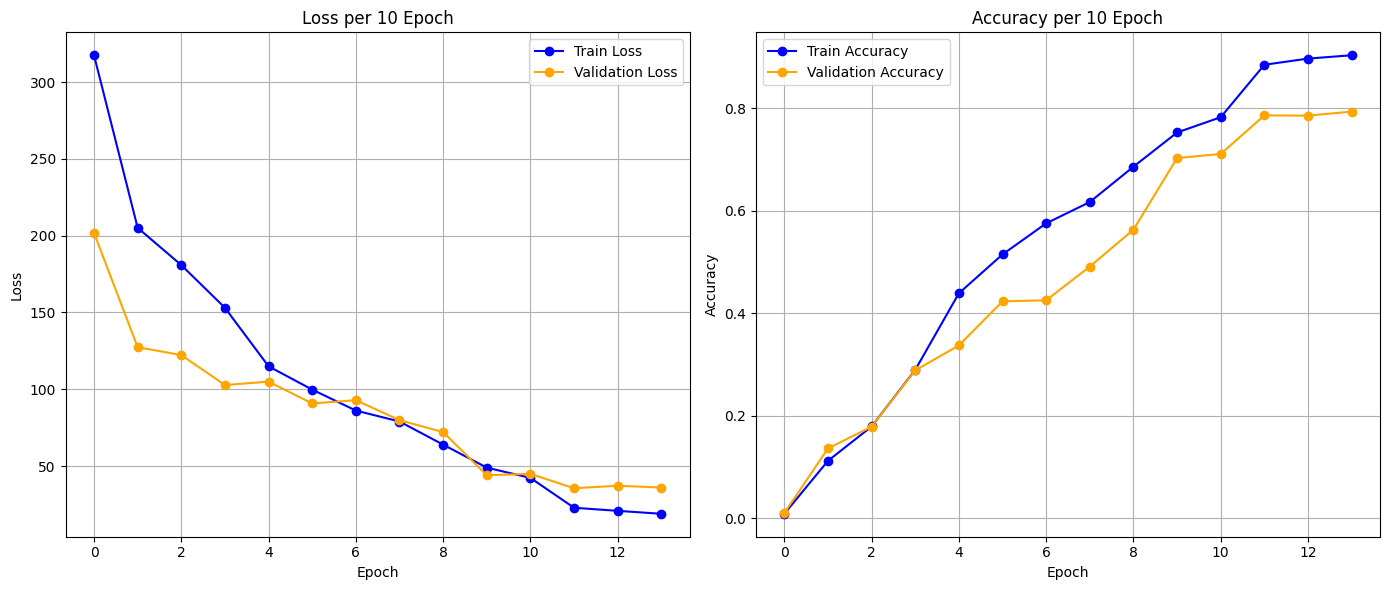

In [ ]:
fit_one_cycle(epochs , my_model, train_loader, test_loader, loss_function, optimizer)

### Load lại mô hình tốt nhất lưu được

In [ ]:
evaluate_model = STGCN_Model(num_class = num_class)

checkpoint = torch.load("/content/drive/MyDrive/gait_recognition/stgcn_model_2.pth")
# new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}  # Remove prefix
evaluate_model.load_state_dict(checkpoint)

#evaluate_model.load_state_dict(torch.load("best_model.pth"))

evaluate_model.to(device)

STGCN_Model(
  (data_bn): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (st_gcn_networks): ModuleList(
    (0): st_gcn(
      (gcn): GraphicalConvNet(
        (conv): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.5, inplace=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1-3): 3 x st_gcn(
      (gcn): GraphicalConvNet(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(9, 1), s

### Đánh giá trên tập test_loader, tiêu chí đánh giá là Accuracy, confusion matrix và classification report

Accuracy on test data: 0.804933


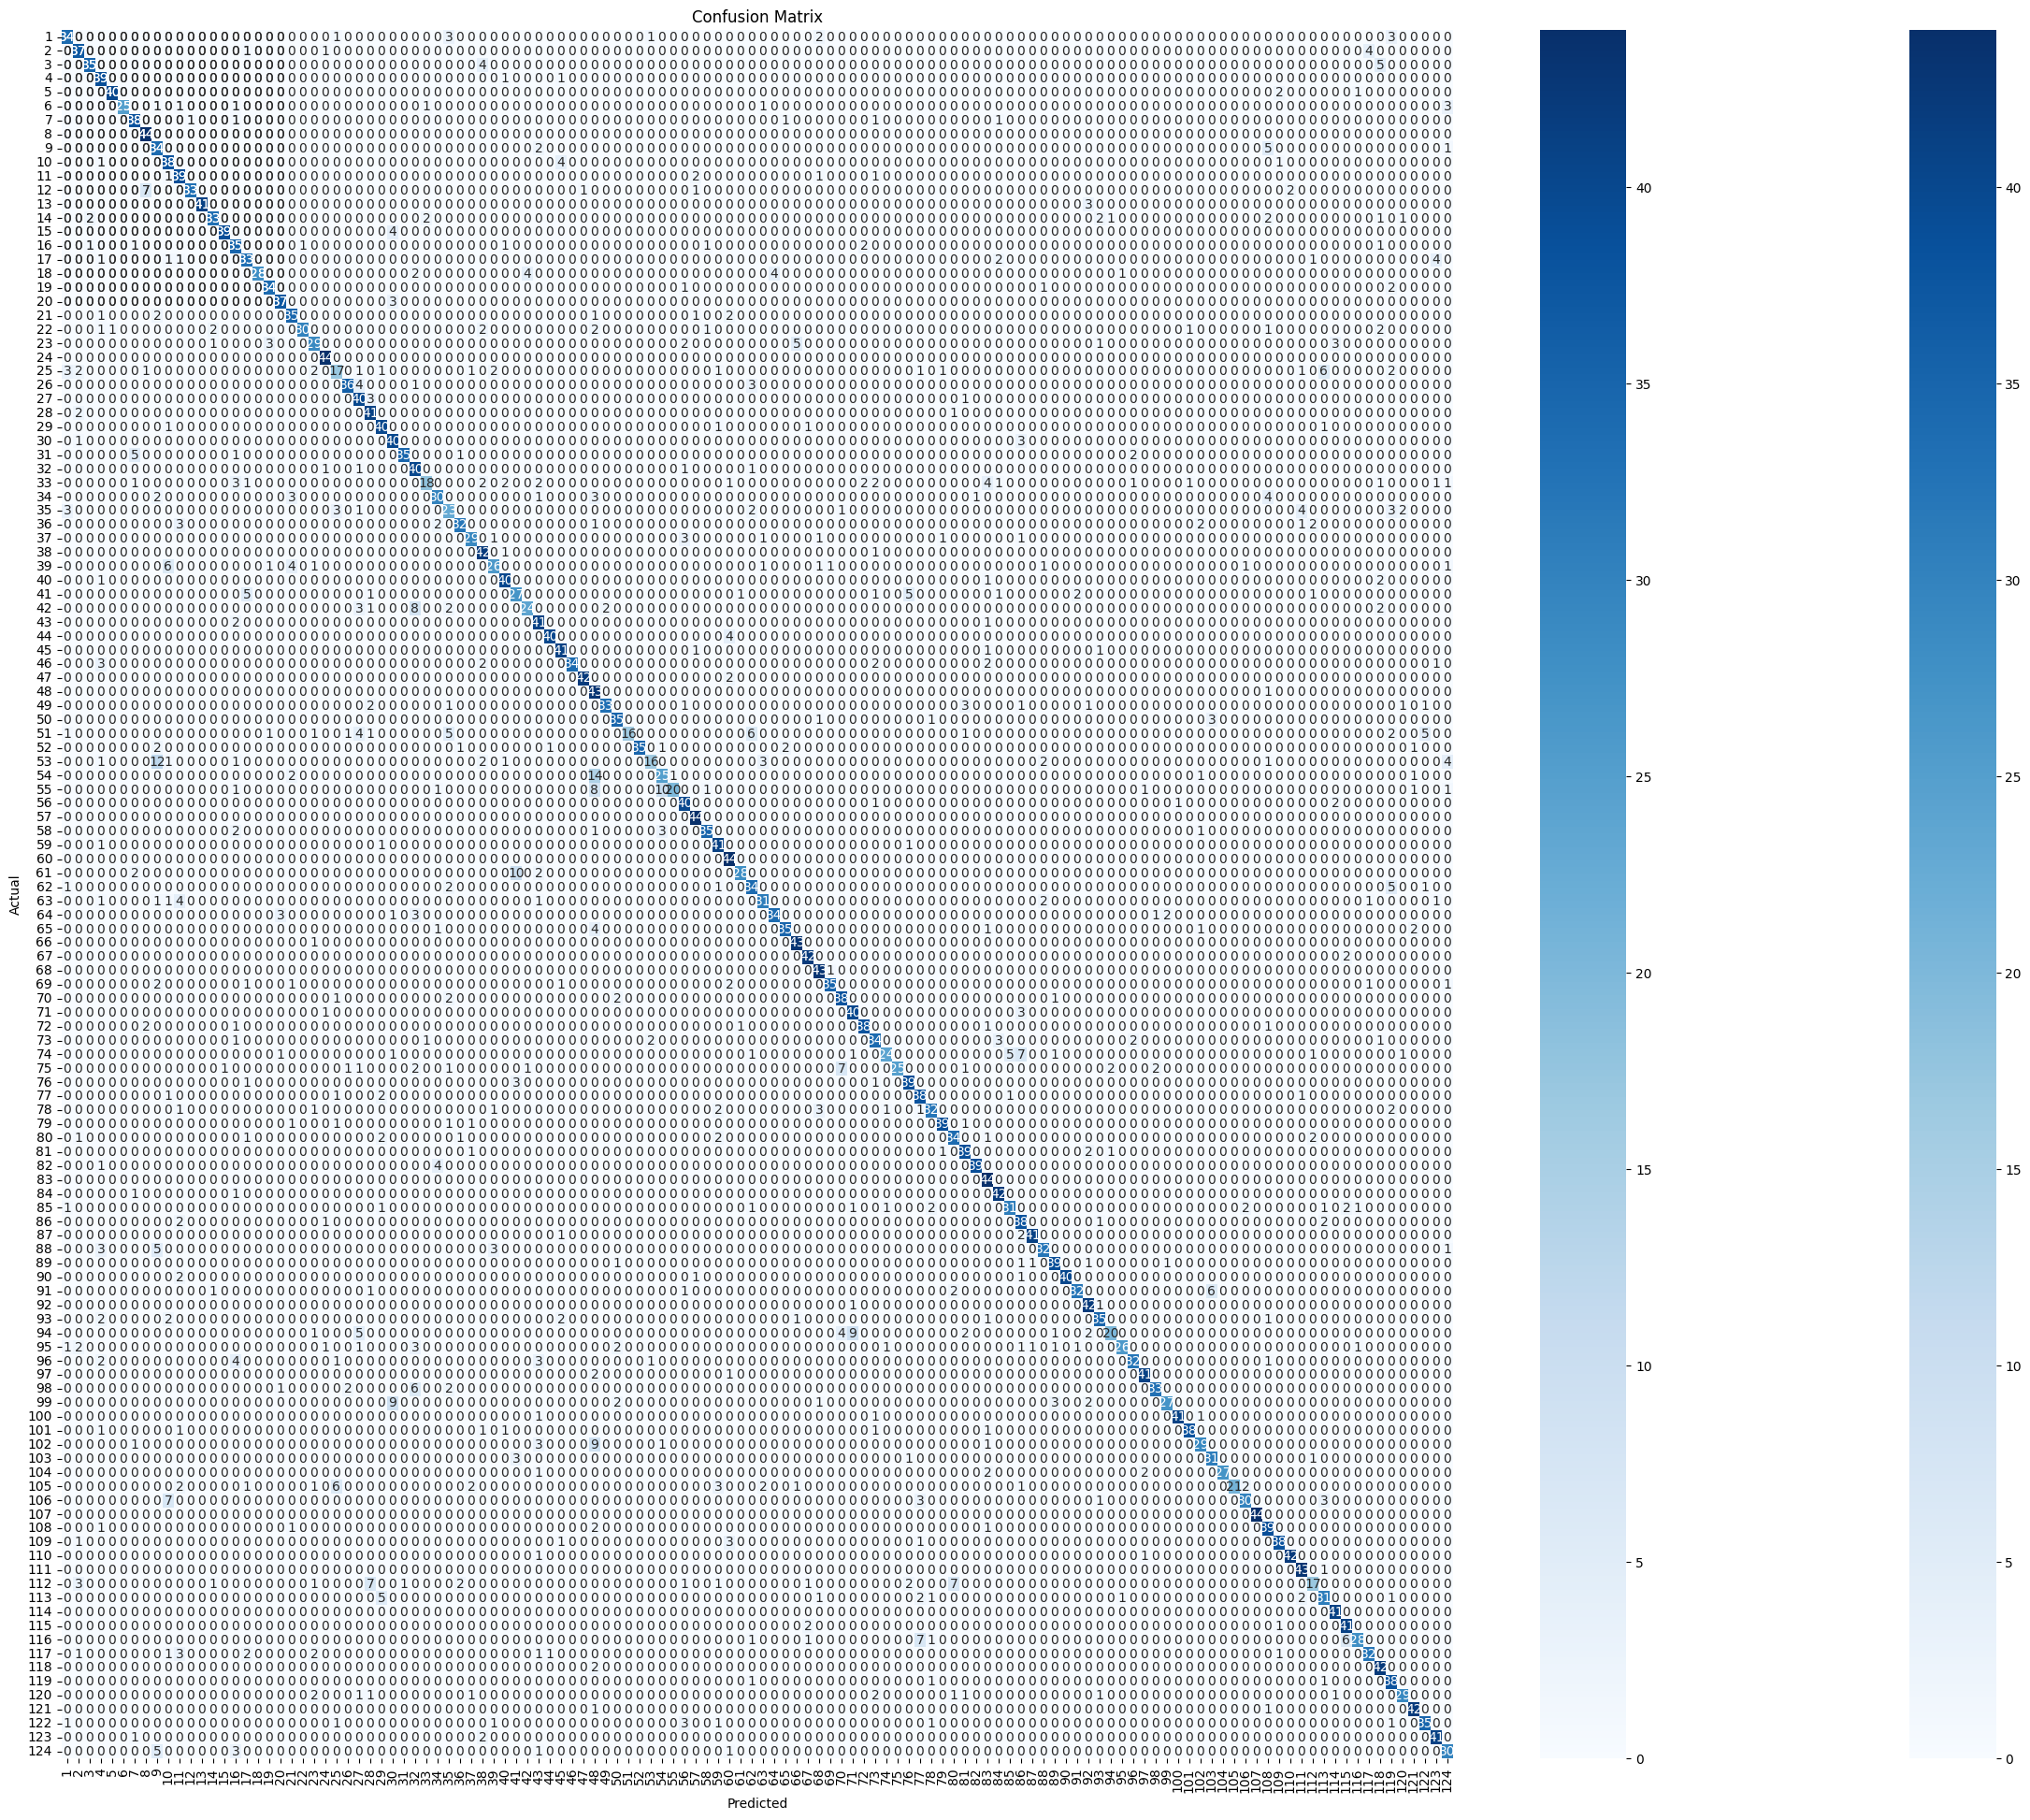


Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.77      0.76        44
           1       0.74      0.86      0.80        43
           2       0.92      0.80      0.85        44
           3       0.65      0.95      0.77        41
           4       0.98      0.93      0.95        43
           5       1.00      0.76      0.86        33
           6       0.76      0.88      0.82        43
           7       0.81      1.00      0.90        44
           8       0.52      0.81      0.63        42
           9       0.63      0.86      0.73        44
          10       0.66      0.89      0.76        44
          11       0.97      0.75      0.85        44
          12       1.00      0.93      0.96        44
          13       0.87      0.75      0.80        44
          14       0.97      0.91      0.94        43
          15       0.61      0.81      0.70        43
          16       0.72      0.77      0.74        43
 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

evaluate_model.eval()
correct = 0
all_labels = []
all_predictions = []
test_N = len(test_loader.dataset)
class_names = []

for i in range(1 , 125):
    class_names.append(str(i))

for inputs, labels in test_loader:
    labels = labels.to(device)
    inputs = inputs.to(device)

    # output = model(inputs)
    # print(output.min().item(), output.max().item())

    outputs = evaluate_model(inputs)

    labels_pred = outputs.argmax(dim=1)
    acc = (labels_pred == labels).float().sum().item()

    correct += acc

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(labels_pred.cpu().numpy())

# Clear CUDA cache
#torch.cuda.empty_cache()
cm = confusion_matrix(all_labels, all_predictions)
report = classification_report(all_labels, all_predictions)

avg_acc = correct/test_N

print(f"Accuracy on test data: {avg_acc:.6f}")
plt.figure(figsize=(30, 24))
sns.heatmap(cm[:20, :20], annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report: \n", report)

In [ ]:
from torch.utils.data import Sampler
import random
from collections import defaultdict

class OneSamplePerIDSampler(Sampler):
    """
    Sampler để chọn đúng 1 sample từ mỗi ID trong một epoch.
    Mỗi batch sẽ chứa tất cả các ID không trùng lặp.
    """

    def __init__(self, dataset, id_position=1):
        """
        dataset: Dataset trả về (data, label)
        id_position: index của ID trong item trả về. Mặc định là 1.
        """
        self.dataset = dataset
        self.id_position = id_position
        self.id_to_indices = self._build_id_index_map()

    def _build_id_index_map(self):
        id_map = defaultdict(list)
        for idx in range(len(self.dataset)):
            item = self.dataset[idx]
            label = item[self.id_position]
            id_map[label].append(idx)
        return id_map

    def __iter__(self):
        sampled_indices = []
        for ID in sorted(self.id_to_indices.keys()):
            indices = self.id_to_indices[ID]
            sampled_idx = random.choice(indices)
            sampled_indices.append(sampled_idx)

        random.shuffle(sampled_indices)  # Shuffle batch order
        return iter(sampled_indices)

    def __len__(self):
        # Mỗi ID một sample
        return len(self.id_to_indices)

## Kiểm tra phân bố của các vector đặc trưng của các ID (kiểm tra xem các ID giống nhau có nằm ở cùng một cluster của nó hay không)

In [ ]:
# dataset_class = dataset_factory('casia-b')
# train_dataset = dataset_class(train_file_path, train=True, sequence_length=60, transform=train_transform)

# test_dataset = dataset_class(test_file_path, sequence_length=60, transform=test_transform)

In [ ]:
# all_data_train = []
# all_labels_train = []
# all_data_test = []
# all_labels_test = []

# for i in range(len(train_dataset)):
#     data, label = train_dataset[i]
#     all_data_train.append(data)
#     all_labels_train.append(label)

# for i in range(len(test_dataset)):
#     data, label = test_dataset[i]
#     all_data_test.append(data)
#     all_labels_test.append(label)

# all_data_train = np.stack(all_data_train)         # (N, C, T, V)
# print(all_data_train.shape)
# all_labels_train = np.array(all_labels_train)
# print(all_labels_train.shape)
# all_data_test = np.stack(all_data_train)         # (N, C, T, V)
# print(all_data_test.shape)
# all_labels_test = np.array(all_labels_train)
# print(all_labels_test.shape)

(7989, 3, 60, 17)
(7989,)
(7989, 3, 60, 17)
(7989,)


In [ ]:
# import csv

# # Đảm bảo model ở chế độ đánh giá
# evaluate_model.eval()

# def write_embeddings_to_csv(data_array, label_array, output_csv):
#     rows = []

#     with torch.no_grad():
#         for i in range(len(data_array)):
#             data = torch.tensor(data_array[i], dtype=torch.float32).unsqueeze(0).to(device)  # (1, C, T, V)
#             label = int(label_array[i])

#             # Xuất embedding
#             embedding = evaluate_model(data)  # hoặc: model(data)
#             embedding = embedding.squeeze().cpu().numpy()

#             row = [label, ' '.join(f"{x:.6f}" for x in embedding)]
#             rows.append(row)

#     # Ghi vào CSV
#     with open(output_csv, "w", newline='') as f:
#         writer = csv.writer(f)
#         writer.writerow(['ID', 'Embedding'])
#         writer.writerows(rows)

# # Gọi hàm ghi cho cả train và test
# write_embeddings_to_csv(all_data_train, all_labels_train, '/content/drive/MyDrive/gait_recognition/train_embed.csv')
# write_embeddings_to_csv(all_data_test, all_labels_test, '/content/drive/MyDrive/gait_recognition/test_embed.csv')


In [ ]:
import pandas as pd
from sklearn.manifold import TSNE

# Load train/test CSV
df_train = pd.read_csv("/content/drive/MyDrive/gait_recognition/train_embed.csv")
df_test = pd.read_csv("/content/drive/MyDrive/gait_recognition/test_embed.csv")

# # Gộp train và test nếu muốn visualize toàn bộ
# df = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
# Parse embeddings
embeddings = df_train['Embedding'].apply(lambda x: np.array([float(i) for i in x.split()]))
X = np.stack(embeddings.to_numpy())  # Shape (N, 124)
y = df_train['ID'].astype(int).to_numpy()  # Shape (N,)

### Sử dụng T-SNE để giảm chiều từ 124D -> 2D

In [ ]:
# t-SNE giảm chiều
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_2d = tsne.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


### Nếu lấy tất cả 124 ID thì sẽ khá khó nhìn

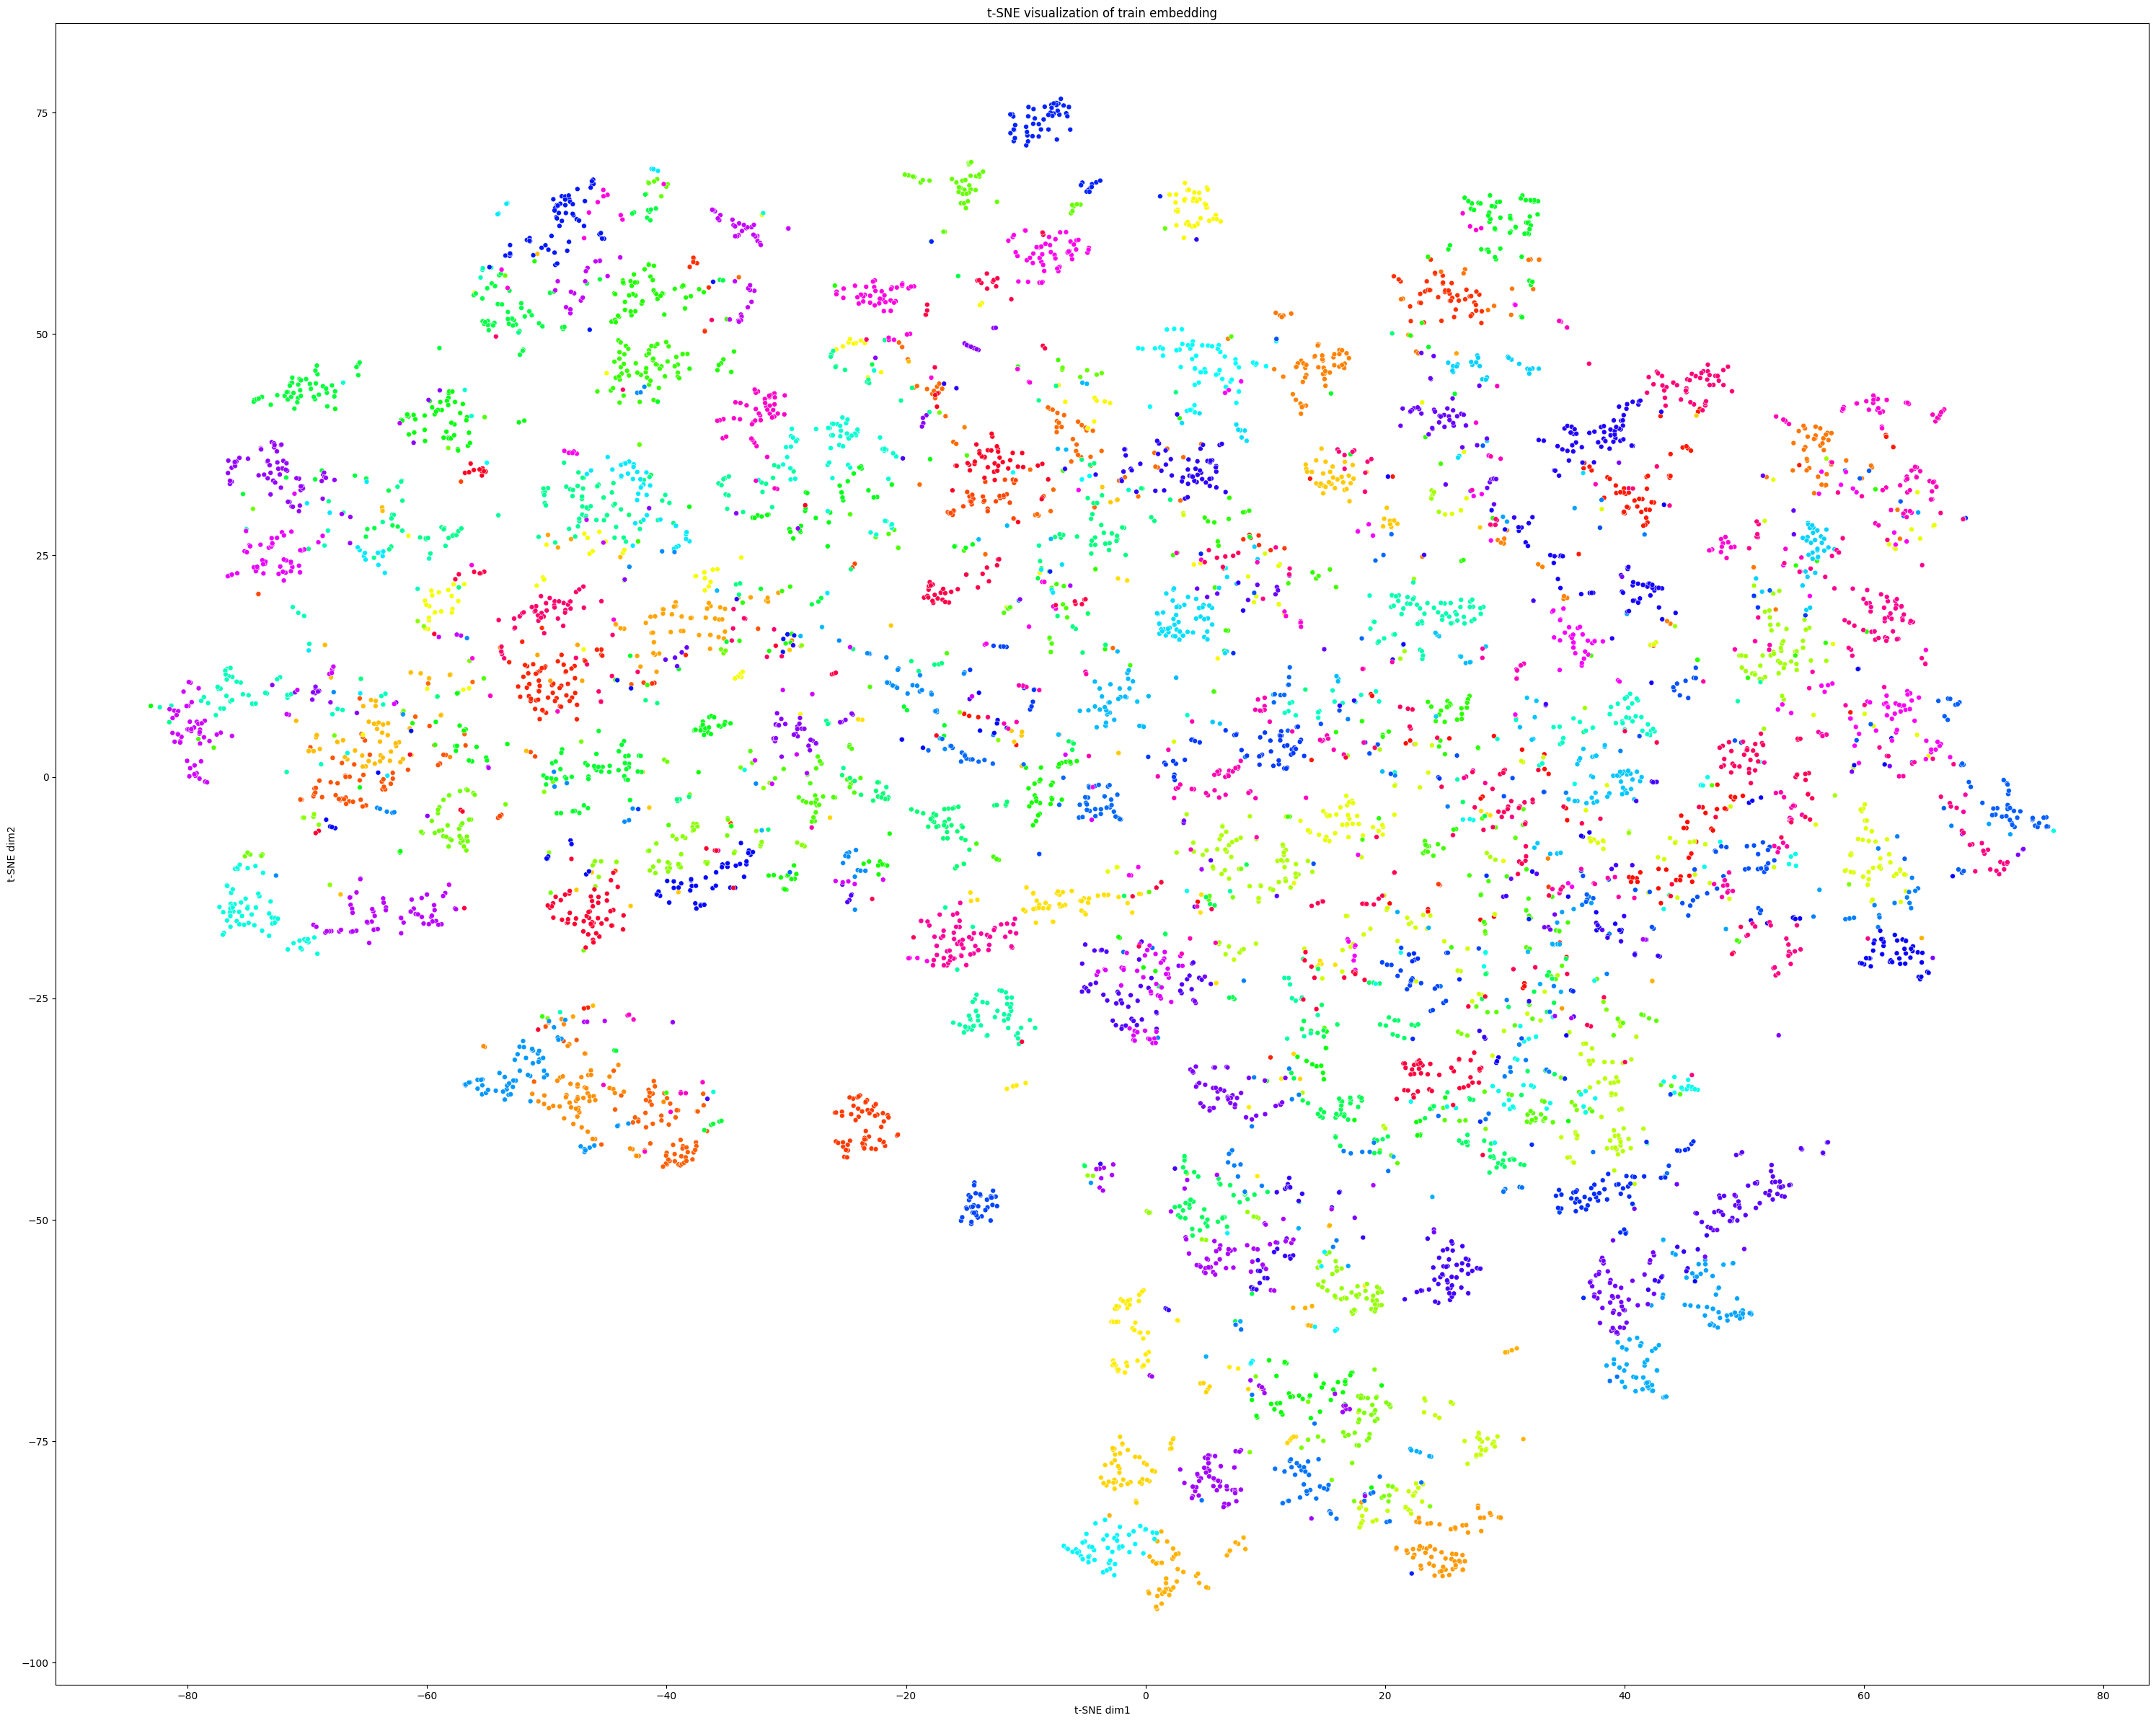

In [ ]:
plt.figure(figsize=(30, 24))
palette = sns.color_palette("hsv", len(np.unique(y)))  # màu khác nhau cho từng ID

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y, palette=palette, legend=False, s=25)

plt.title("t-SNE visualization of train embedding")
plt.xlabel("t-SNE dim1")
plt.ylabel("t-SNE dim2")
plt.tight_layout()
plt.show()

### Lấy 20 ID đầu

In [ ]:
unique_ids = np.unique(y)[:20]  # chỉ lấy 20 ID đầu
mask = np.isin(y, unique_ids)

X_subset = X[mask]
y_subset = y[mask]

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_2d = tsne.fit_transform(X_subset)

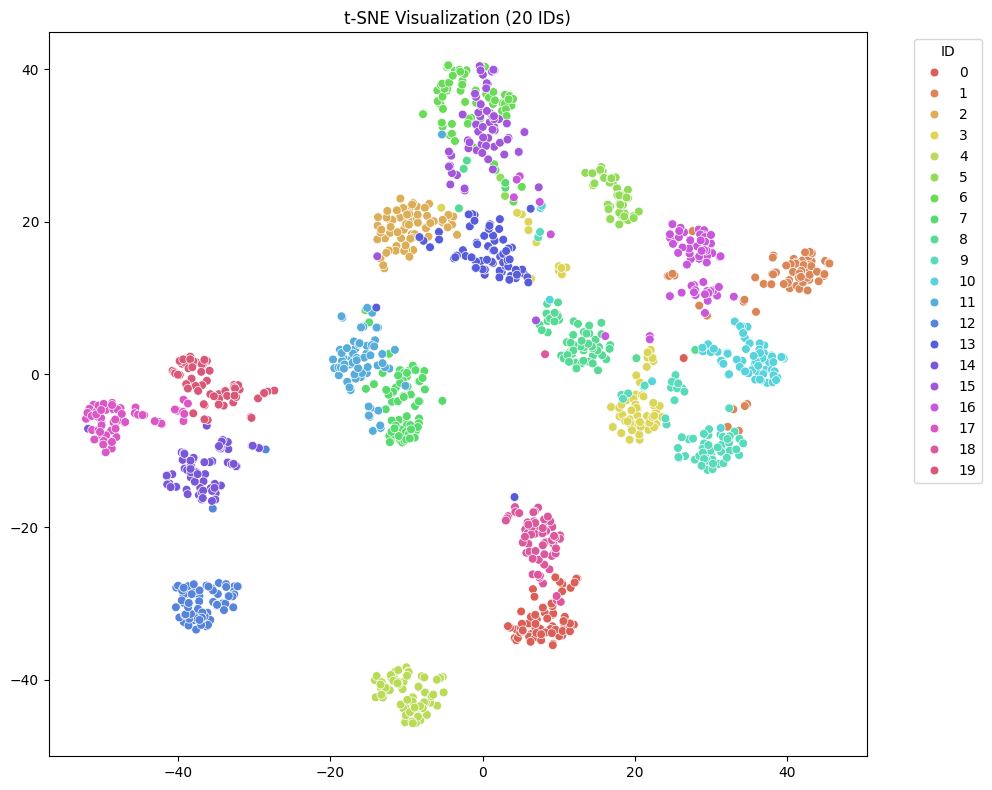

In [ ]:
# Vẽ
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hls", len(unique_ids))  # bảng màu với số màu = số ID

sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=y_subset,
    palette=palette,
    legend='full',
    s=40
)

# Chỉnh lại legend để hiển thị rõ
plt.legend(title='ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Visualization (20 IDs)")
plt.tight_layout()
plt.show()

### Bây giờ qua kiểm tra trên tập test, (giống với khi kiểm tra bên train thì mô hình học tốt)

In [ ]:
embeddings = df_test['Embedding'].apply(lambda x: np.array([float(i) for i in x.split()]))
X = np.stack(embeddings.to_numpy())  # Shape (N, 124)
y = df_test['ID'].astype(int).to_numpy()  # Shape (N,)

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_2d = tsne.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


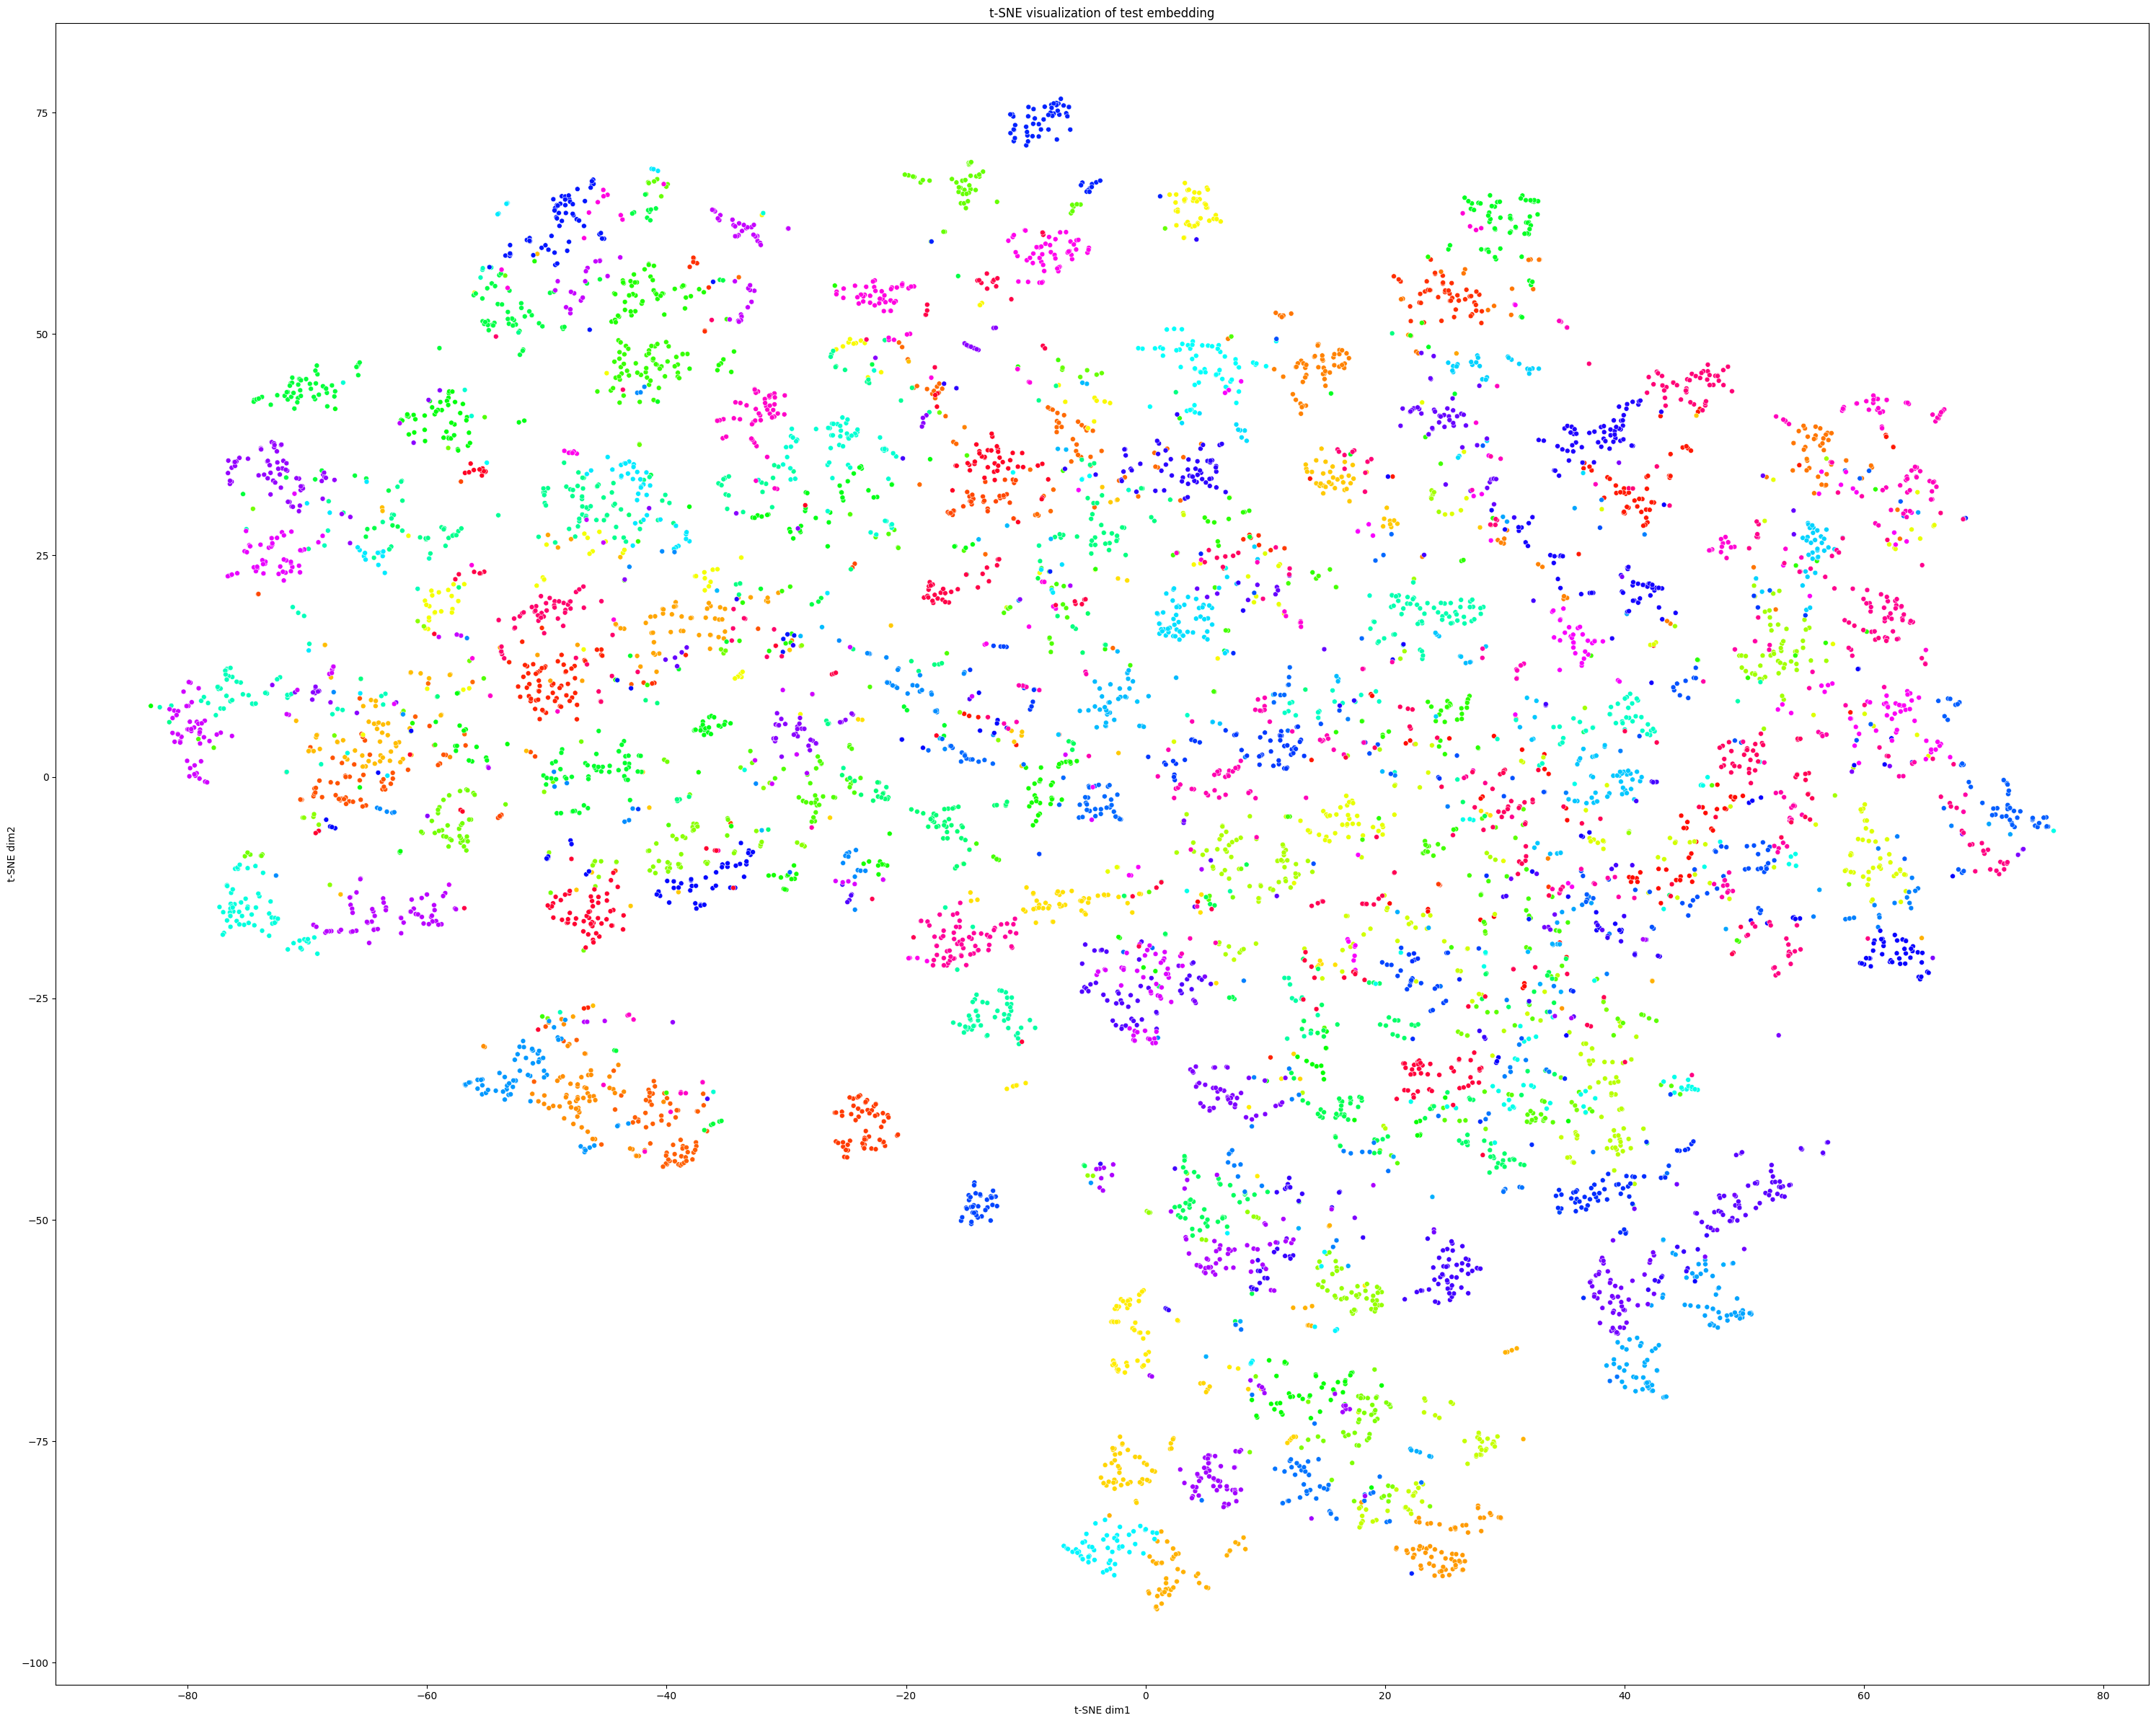

In [ ]:
plt.figure(figsize=(30, 24))
palette = sns.color_palette("hsv", len(np.unique(y)))  # màu khác nhau cho từng ID

sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=y, palette=palette, legend=False, s=25)

plt.title("t-SNE visualization of test embedding")
plt.xlabel("t-SNE dim1")
plt.ylabel("t-SNE dim2")
plt.tight_layout()
plt.show()

In [ ]:
unique_ids = np.unique(y)[:20]  # chỉ lấy 20 ID đầu
mask = np.isin(y, unique_ids)

X_subset = X[mask]
y_subset = y[mask]

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
X_2d = tsne.fit_transform(X_subset)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


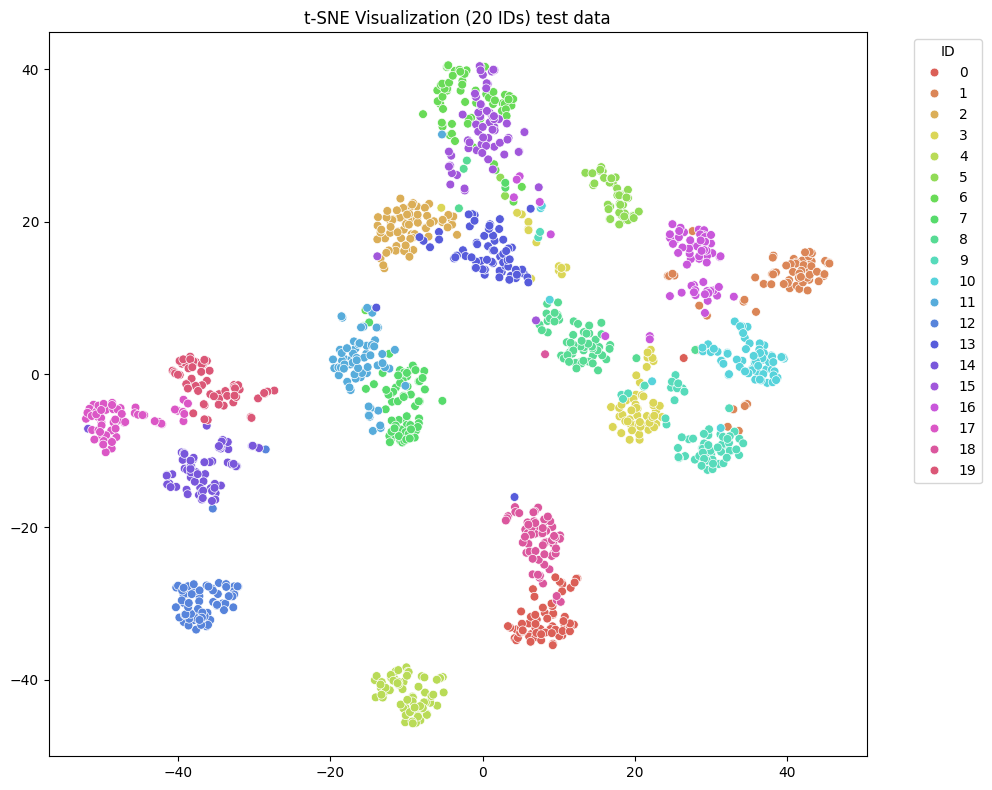

In [ ]:
# Vẽ
plt.figure(figsize=(10, 8))
palette = sns.color_palette("hls", len(unique_ids))  # bảng màu với số màu = số ID

sns.scatterplot(
    x=X_2d[:, 0],
    y=X_2d[:, 1],
    hue=y_subset,
    palette=palette,
    legend='full',
    s=40
)

# Chỉnh lại legend để hiển thị rõ
plt.legend(title='ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Visualization (20 IDs) test data")
plt.tight_layout()
plt.show()

### Implement HRNet để nhận diện thêm dữ liệu từ User thêm vào

In [ ]:
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [21]:
input_path = "/content/drive/MyDrive/gait_recognition/new_gait/125.mp4"

In [22]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open(input_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=640 controls>
  <source src="{data_url}" type="video/mp4">
</video>
""")

In [24]:
import cv2
import os
import pandas as pd

### Đếm số frame (phải > 60 frame)

In [ ]:
cap = cv2.VideoCapture(input_path)

# Kiểm tra xem mở thành công chưa
if not cap.isOpened():
    print("Không thể mở video.")
else:
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1

    cap.release()
    print(f"Tổng số frame trong video: {frame_count}")

Tổng số frame trong video: 117


In [ ]:
# import shutil

# !rm -rf /content/drive/MyDrive/gait_recognition/new_gait/125

### Tách các frame ra và lưu vào một thư mục để đưa vào HRNet

In [ ]:
output_dir = "/content/drive/MyDrive/gait_recognition/new_gait/125/nm-01/000"
os.makedirs(output_dir, exist_ok=True)
id = "125"
gait_type = "nm"
seq_num = "01"
angle = "000"

cap = cv2.VideoCapture(input_path)
frame_idx = 1

while True:
    ret, frame = cap.read()
    if not ret:
        break
    cv2.imwrite(f"{output_dir}/{id}-{gait_type}-{seq_num}-{angle}-{frame_idx:06d}.jpg", frame)
    frame_idx += 1

cap.release()
print(f"Đã lưu {frame_idx} frame vào thư mục: {output_dir}")

Đã lưu 118 frame vào thư mục: /content/drive/MyDrive/gait_recognition/new_gait/125/nm-01/000


In [ ]:
def save_image_names_to_csv(base_folder, ID, gait_type, seq_num, angle, output_csv):
    pass_line = gait_type + "-" + seq_num
    folder_path = os.path.join(base_folder, ID, pass_line, angle)
    all_files = sorted(os.listdir(folder_path))

    image_names = []
    for i, file in enumerate(all_files):
        index_str = str(i+1).zfill(6)  # Từ 000001 đến 000112
        image_name = f"{ID}-{gait_type}-{seq_num}-{angle}-{index_str}.jpg"
        image_names.append(image_name)

    df = pd.DataFrame(image_names, columns=["image_name"])
    df.to_csv(output_csv, index=False)
    print(f"Đã lưu vào: {output_csv}")

In [ ]:
save_image_names_to_csv(
    base_folder='/content/drive/MyDrive/gait_recognition/new_gait',
    ID='125',
    gait_type='nm',
    seq_num='01',
    angle='000',
    output_csv='/content/drive/MyDrive/gait_recognition/new_gait/new_add_image_list.csv'
)

Đã lưu vào: /content/drive/MyDrive/gait_recognition/new_gait/new_add_image_list.csv


In [ ]:
!pip install yacs

### Quá trình lấy được giá trị các joint từ một frame RGB đầu vào sẽ như sau:
* Frame sẽ được đưa vào mô hình YOLO-v3 trước để lấy tọa độ ví trí có người gồm x, y, w, h
* Sau đó, sẽ được đưa kết quả detection được đó vào HRNet để nhận diện vị trí các khớp

In [ ]:
!python3 /content/drive/MyDrive/gait_recognition/HRNet/Detector/prepare_detection.py /content/drive/MyDrive/gait_recognition/new_gait/125/nm-01/000 /content/drive/MyDrive/gait_recognition/new_gait/new_add_image_list.csv /content/drive/MyDrive/gait_recognition/new_gait/new_add_detections.csv

Data loaded: 4 batches
  0% 0/4 [00:00<?, ?it/s]/content/drive/MyDrive/gait_recognition/HRNet/Detector/tools/models.py:127: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  self.scaled_anchors = FloatTensor([(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors])
100% 4/4 [00:04<00:00,  1.01s/it]


In [ ]:
!python3 /content/drive/MyDrive/gait_recognition/HRNet/prepare_pose_estimation.py  /content/drive/MyDrive/gait_recognition/new_gait/125/nm-01/000 /content/drive/MyDrive/gait_recognition/new_gait/new_add_detections.csv /content/drive/MyDrive/gait_recognition/new_gait/new_add_pose_coco.csv

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Data loaded: 7 batches
100% 7/7 [00:02<00:00,  2.78it/s]


### Ghép kết quả vào file train và test để mô hình học lại từ dữ liệu mới

In [ ]:
csv_path = "/content/drive/MyDrive/gait_recognition/new_gait/new_add_pose_coco.csv"

# Load file
df = pd.read_csv(csv_path)

# Hàm đổi tên
def transform_image_name(name):
    parts = name.split("-")
    prefix = "-".join(parts[:4])  # "125-nm-01-000"
    suffix = parts[-1].replace(".jpg", "")[-6:]  # "000001"
    return f"./{prefix}/{suffix}.jpg"

# Áp dụng hàm đổi tên
df['image_name'] = df['image_name'].apply(transform_image_name)

# Lưu lại nếu muốn
df.to_csv("/content/drive/MyDrive/gait_recognition/new_gait/new_add_pose_coco_2.csv", index=False)

print("✅ Đổi tên xong. Một vài ví dụ:")
print(df['image_name'].head())

✅ Đổi tên xong. Một vài ví dụ:
0    ./125-nm-01-000/000001.jpg
1    ./125-nm-01-000/000002.jpg
2    ./125-nm-01-000/000003.jpg
3    ./125-nm-01-000/000004.jpg
4    ./125-nm-01-000/000005.jpg
Name: image_name, dtype: object


In [ ]:
csv1 = "/content/drive/MyDrive/gait_recognition/train.csv"
csv2 = "/content/drive/MyDrive/gait_recognition/new_gait/new_add_pose_coco_2.csv"

# Đọc 2 file
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Nối file thứ hai vào sau file thứ nhất
merged_df = pd.concat([df1, df2], ignore_index=True)

# Lưu lại nếu muốn
merged_df.to_csv("/content/drive/MyDrive/gait_recognition/new_gait/new_add_train.csv", index=False)

print("✅ Đã ghép xong. Tổng số dòng:", len(merged_df))

✅ Đã ghép xong. Tổng số dòng: 756149


In [25]:
csv1 = "/content/drive/MyDrive/gait_recognition/test.csv"
csv2 = "/content/drive/MyDrive/gait_recognition/new_gait/new_add_pose_coco_2.csv"

# Đọc 2 file
df1 = pd.read_csv(csv1)
df2 = pd.read_csv(csv2)

# Nối file thứ hai vào sau file thứ nhất
merged_df = pd.concat([df1, df2], ignore_index=True)

# Lưu lại nếu muốn
merged_df.to_csv("/content/drive/MyDrive/gait_recognition/new_gait/new_add_valid.csv", index=False)

print("✅ Đã ghép xong. Tổng số dòng:", len(merged_df))

✅ Đã ghép xong. Tổng số dòng: 509820


### Đường dẫn đến dữ liệu mới

In [27]:
train_file_path = "/content/drive/MyDrive/gait_recognition/new_gait/new_add_train.csv"
valid_file_path = "/content/drive/MyDrive/gait_recognition/new_gait/new_add_valid.csv"
test_file_path = "/content/drive/MyDrive/gait_recognition/new_gait/new_add_pose_coco_2.csv"

### test dataset sẽ chỉ gồm một mẫu duy nhất kích thước (3,60,17)

In [28]:
dataset_class = dataset_factory('casia-b')
train_dataset = dataset_class(train_file_path, train=True, sequence_length=60, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
train_N = len(train_loader.dataset)
print(train_N)

valid_dataset = dataset_class(valid_file_path, sequence_length=60, transform=test_transform)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)
valid_N = len(valid_loader.dataset)
print(valid_N)

test_dataset = dataset_class(test_file_path, sequence_length=60, transform=test_transform)
test_N = len(test_dataset)
print(test_N)

7990
5353
1


In [44]:
print(test_dataset[0])

(tensor([[[1.3489e+02, 1.2264e+02, 1.3600e+02,  ..., 9.5916e+01,
          1.0538e+02, 1.4269e+02],
         [1.3607e+02, 1.3937e+02, 1.3497e+02,  ..., 9.6514e+01,
          1.6134e+02, 1.3058e+02],
         [1.3581e+02, 1.8718e+02, 1.2353e+02,  ..., 9.6725e+01,
          1.0398e+02, 9.6725e+01],
         ...,
         [3.0884e+02, 3.1559e+02, 2.9684e+02,  ..., 2.7284e+02,
          2.3308e+02, 2.3308e+02],
         [2.2165e+02, 2.1826e+02, 2.1826e+02,  ..., 2.7750e+02,
          2.9222e+02, 2.3373e+02],
         [2.2288e+02, 2.2131e+02, 2.2131e+02,  ..., 2.8186e+02,
          2.3811e+02, 2.4045e+02]],

        [[1.2099e+02, 2.6339e+01, 8.8699e+01,  ..., 1.2656e+02,
          2.2400e+02, 1.7333e+02],
         [1.1538e+02, 1.0769e+02, 1.0439e+02,  ..., 1.2527e+02,
          1.7801e+02, 1.8571e+02],
         [1.1130e+02, 1.2023e+02, 1.1130e+02,  ..., 1.2358e+02,
          2.2464e+02, 2.2297e+02],
         ...,
         [1.1387e+02, 1.1237e+02, 1.0337e+02,  ..., 1.1312e+02,
          1.13

### Define lại mô hình num_class bây giờ bằng 125

In [29]:
num_class = 125

new_add_model = STGCN_Model(num_class = num_class).to(device)

### Tiến hành train lại mô hình

In [35]:
epochs = 1000
learning_rate = 0.01
weight_decay = 0
loss_function = nn.CrossEntropyLoss()
optimizer = gait_recognition.utils.get_trainer(new_add_model,learning_rate,weight_decay)

<ipython-input-33-fa19ce37d1b8>:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-33-fa19ce37d1b8>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Epoch 1/1000
Train loss: 318.6417, Train acc: 0.0101, LR: 0.010000
Validation loss: 196.4922, Validation acc: 0.0135
✅ Model saved with valid loss: 196.4922 , valid accuracy: 0.0135 , lr: 0.010000

Epoch 2/1000
Train loss: 291.8965, Train acc: 0.0170, LR: 0.010000
Validation loss: 190.6154, Validation acc: 0.0202
✅ Model saved with valid loss: 190.6154 , valid accuracy: 0.0202 , lr: 0.010000

Epoch 3/1000
Train loss: 279.1297, Train acc: 0.0209, LR: 0.010000
Validation loss: 187.5793, Validation acc: 0.0166

Epoch 4/1000
Train loss: 266.4139, Train acc: 0.0293, LR: 0.010000
Validation loss: 171.2670, Validation acc: 0.0400
✅ Model saved with valid loss: 171.2670 , valid accuracy: 0.0400 , lr: 0.010000

Epoch 5/1000
Train loss: 255.6863, Train acc: 0.0327, LR: 0.010000
Validation loss: 164.2972, Validation acc: 0.0364

Epoch 6/1000
Train loss: 248.5131, Train acc: 0.0403, LR: 0.010000
Validation loss: 161.4451, Validation acc: 0.0398

Epoch 7/1000
Train loss: 245.4020, Train acc: 0.039

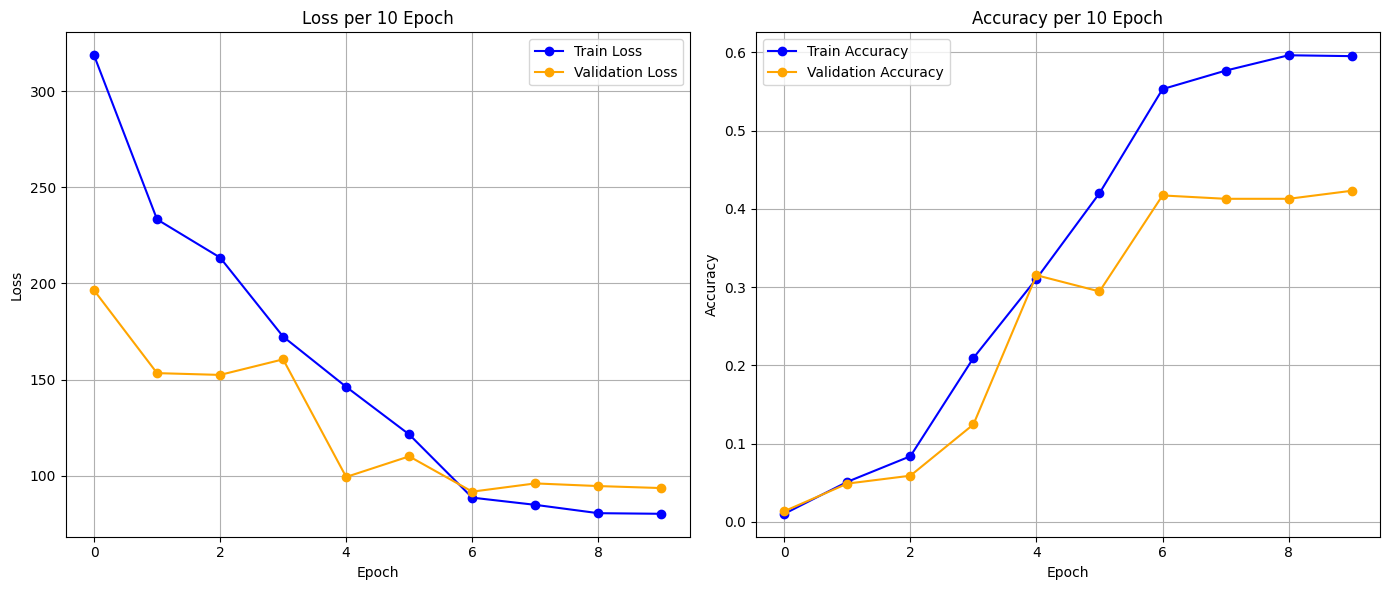

In [36]:
fit_one_cycle(epochs , new_add_model, train_loader, valid_loader, loss_function, optimizer, save_path="/content/drive/MyDrive/gait_recognition/new_gait/stgcn_model_addnewdata.pth")

### Load mô hình tốt nhất để đánh giá

In [37]:
evaluate_new_model = STGCN_Model(num_class = num_class)

checkpoint = torch.load("/content/drive/MyDrive/gait_recognition/new_gait/stgcn_model_addnewdata.pth")
# new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint.items()}  # Remove prefix
evaluate_new_model.load_state_dict(checkpoint)

#evaluate_model.load_state_dict(torch.load("best_model.pth"))

evaluate_new_model.to(device)

STGCN_Model(
  (data_bn): BatchNorm1d(51, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (st_gcn_networks): ModuleList(
    (0): st_gcn(
      (gcn): GraphicalConvNet(
        (conv): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.5, inplace=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1-3): 3 x st_gcn(
      (gcn): GraphicalConvNet(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (tcn): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(9, 1), s

### Đánh giá trên tập valid dataset:
* ID thứ 125 là ID mới thêm và mô hình không thể nhận dạng được ID này
* Dữ liệu mới thêm vào sẽ làm ảnh hưởng đến độ chính xác nhận diện các ID kia rất nhiều

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy on test data: 0.446105


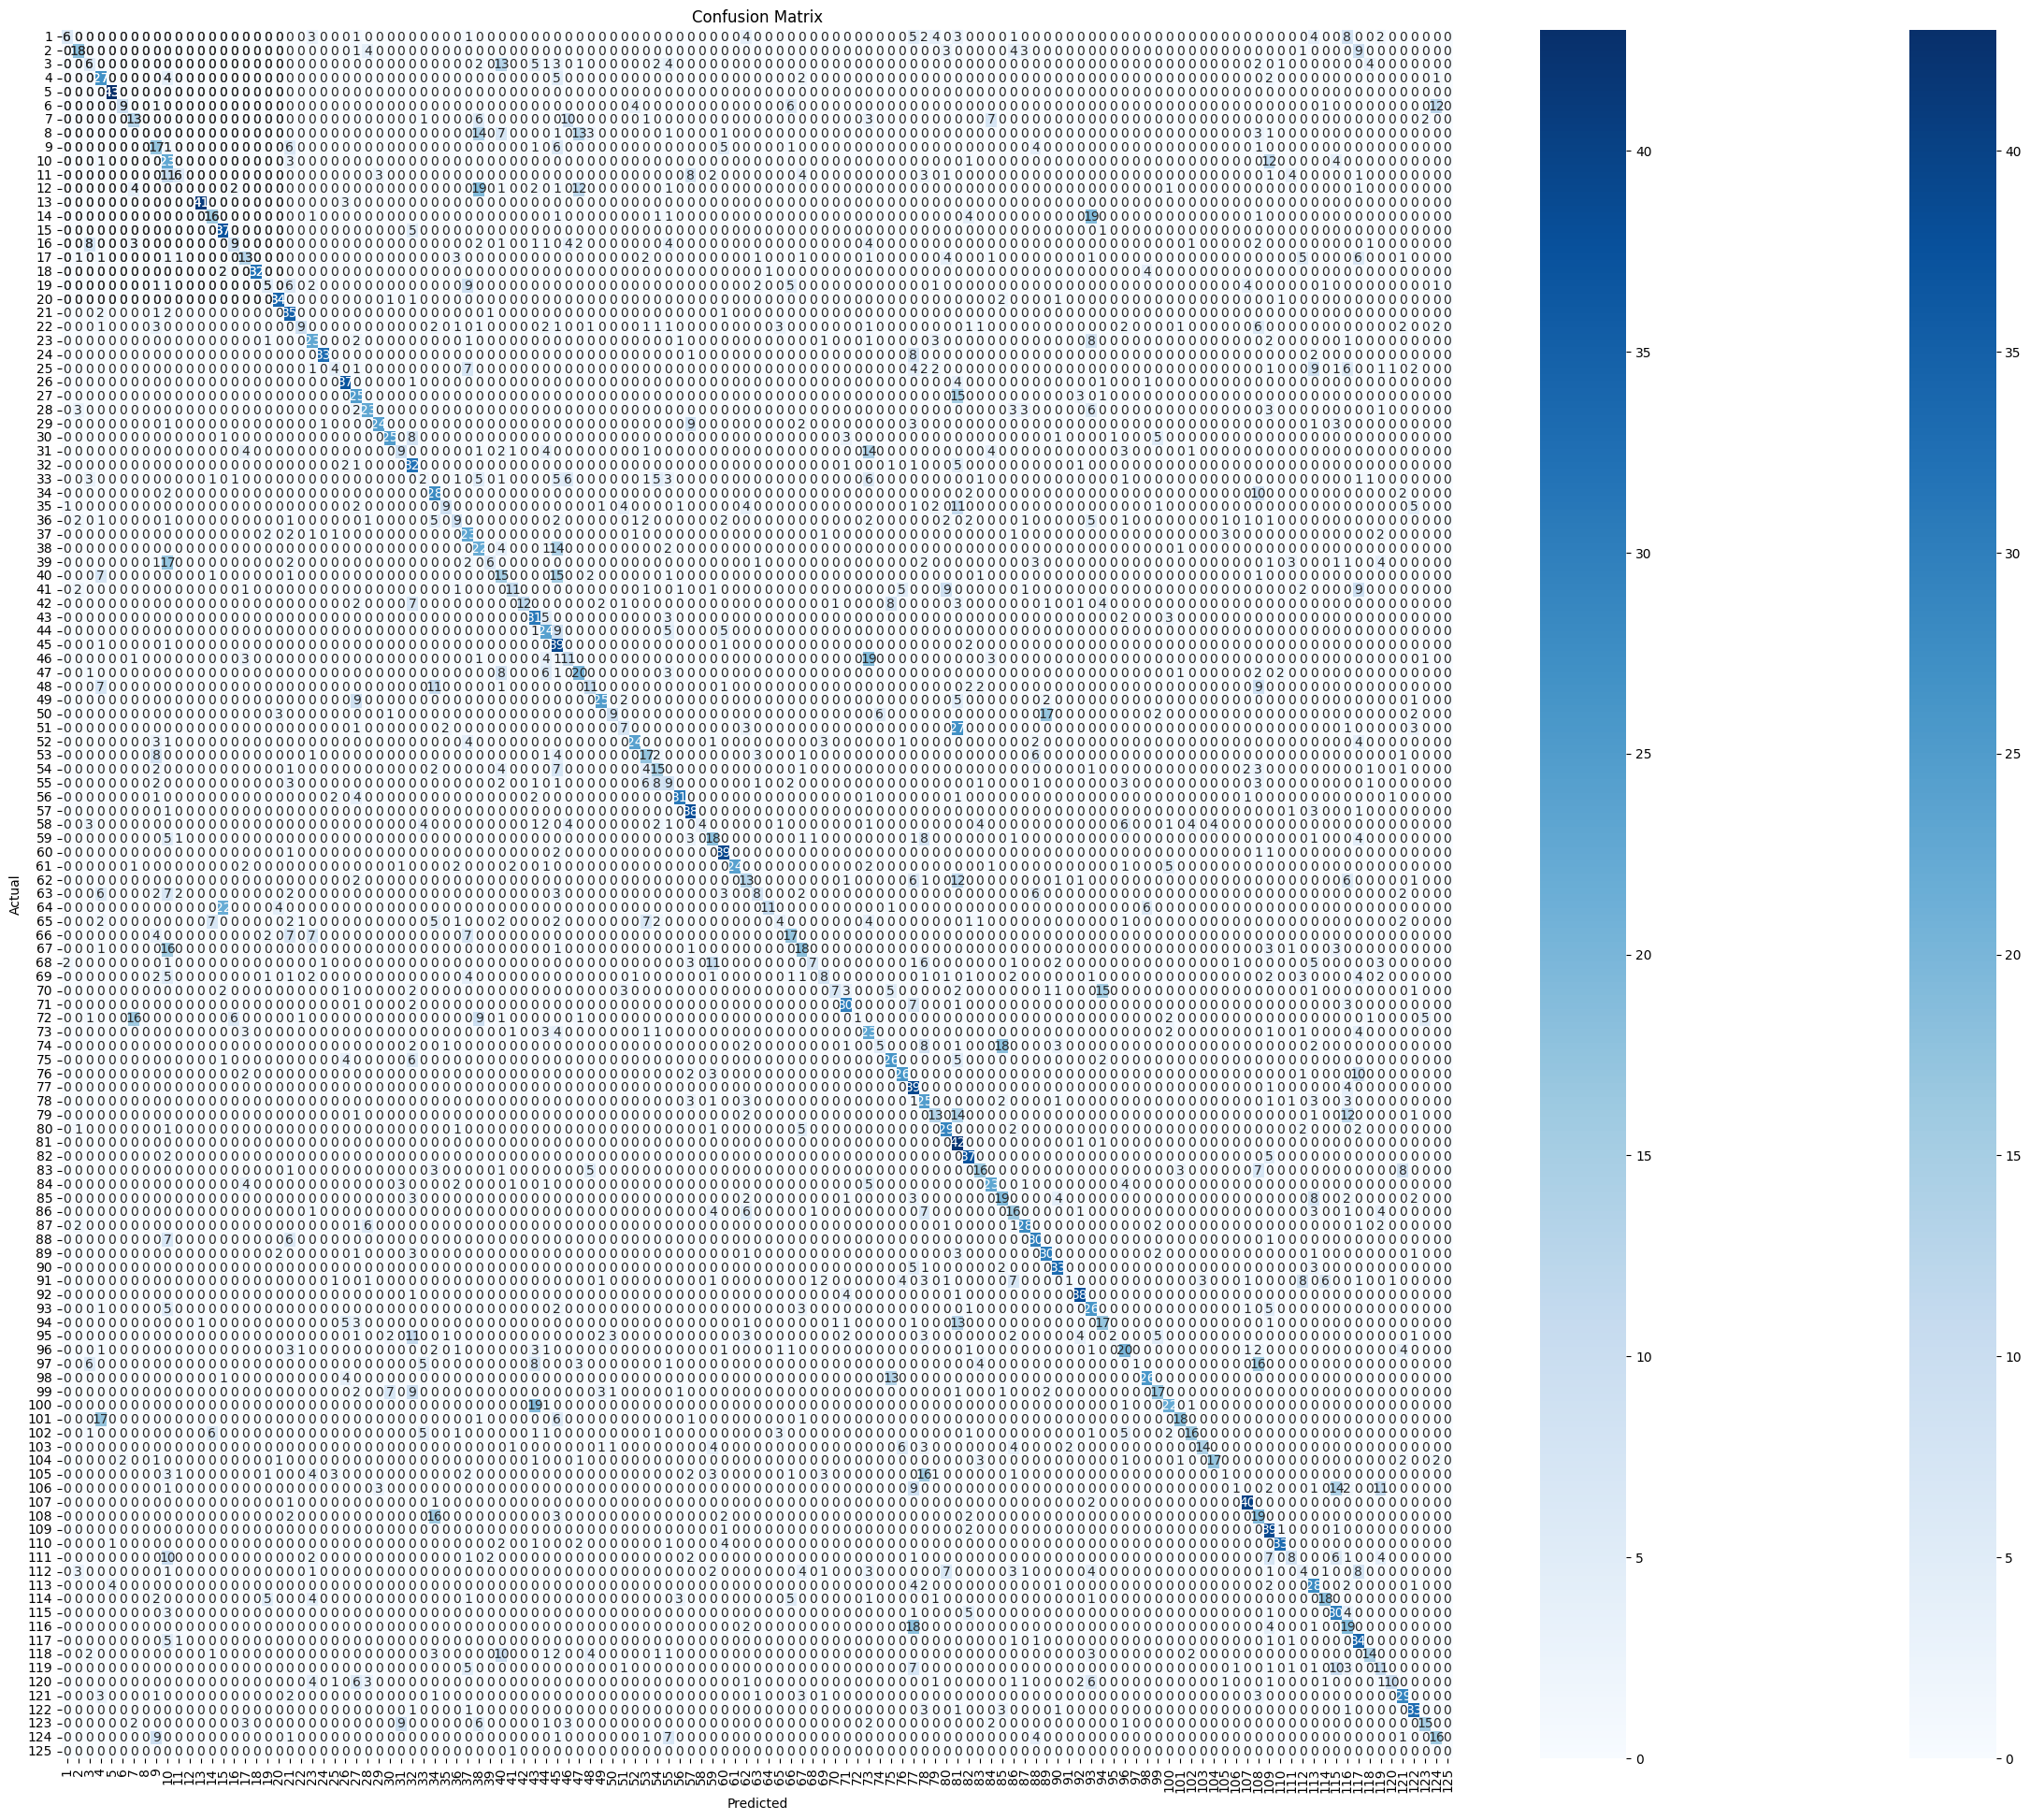


Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.14      0.23        44
           1       0.56      0.42      0.48        43
           2       0.19      0.14      0.16        44
           3       0.34      0.66      0.45        41
           4       0.90      1.00      0.95        43
           5       0.82      0.27      0.41        33
           6       0.33      0.30      0.31        43
           7       0.00      0.00      0.00        44
           8       0.28      0.40      0.33        42
           9       0.17      0.52      0.25        44
          10       0.50      0.14      0.21        44
          11       0.00      0.00      0.00        44
          12       0.98      0.93      0.95        44
          13       0.50      0.36      0.42        44
          14       0.56      0.86      0.68        43
          15       0.50      0.21      0.30        43
          16       0.37      0.30      0.33        43
 

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

evaluate_new_model.eval()
correct = 0
all_labels = []
all_predictions = []
test_N = len(valid_loader.dataset)
class_names = []

for i in range(1 , 126):
    class_names.append(str(i))

for inputs, labels in valid_loader:
    labels = labels.to(device)
    inputs = inputs.to(device)

    # output = model(inputs)
    # print(output.min().item(), output.max().item())

    outputs = evaluate_new_model(inputs)

    labels_pred = outputs.argmax(dim=1)
    acc = (labels_pred == labels).float().sum().item()

    correct += acc

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(labels_pred.cpu().numpy())

# Clear CUDA cache
#torch.cuda.empty_cache()
cm = confusion_matrix(all_labels, all_predictions)
report = classification_report(all_labels, all_predictions)

avg_acc = correct/test_N

print(f"Accuracy on test data: {avg_acc:.6f}")
plt.figure(figsize=(30, 24))
sns.heatmap(cm[:20, :20], annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report: \n", report)

### Kiểm tra riêng ID 125

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

evaluate_new_model.eval()
correct = 0

inputs, labels = test_dataset[0]
print(inputs.shape)

labels = torch.tensor(labels).to(device)
inputs = inputs.to(device)

    # output = model(inputs)
    # print(output.min().item(), output.max().item())

with torch.no_grad():
    outputs = evaluate_new_model(inputs.unsqueeze(0))  # Add batch dim
    labels_pred = outputs.argmax(dim=-1)
    acc = (labels_pred == labels).float().item()

print(f"Predicted ID: {labels_pred.item()}")
print(f"Actual ID: {labels.item()}")

torch.Size([3, 60, 17])
Accuracy predicting ID 125 just add to data: 0.000000
Predicted ID: 40
Actual ID: 124
